# XGBoost Model Analysis
## Comprehensive Analysis of Trained Classification Model

This notebook analyzes the XGBoost model trained for 300s forward profitability prediction using the saved test dataset.

**Model Path**: `/Volumes/Extreme SSD/trading_data/solana/models/classification_forward/`  
**Test Data**: `/Volumes/Extreme SSD/trading_data/solana/models/classification_forward/datasets/test_set.pkl`

### Analysis Objectives:
1. Load trained model and test data
2. Evaluate model performance metrics
3. Analyze feature importance and SHAP values
4. ROC/AUC and Precision-Recall analysis
5. Threshold optimization for trading strategy
6. Error analysis and model interpretability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML and analysis imports
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
import xgboost as xgb
import shap

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")
print(f"XGBoost version: {xgb.__version__}")
print(f"SHAP version: {shap.__version__}")

Libraries imported successfully
XGBoost version: 3.0.2
SHAP version: 0.48.0


## 1. Load Model and Data

In [2]:
# Define paths
MODEL_DIR = "/Volumes/Extreme SSD/trading_data/solana/models/classification_forward"
DATASETS_DIR = f"{MODEL_DIR}/datasets"

# Load trained model
print("Loading trained XGBoost model...")
with open(f"{MODEL_DIR}/best_model.pkl", 'rb') as f:
    model = pickle.load(f)

# Load feature names
with open(f"{MODEL_DIR}/feature_names.pkl", 'rb') as f:
    feature_names = pickle.load(f)

# Load model metadata
with open(f"{MODEL_DIR}/model_metadata.json", 'r') as f:
    model_metadata = json.load(f)

# Load test dataset
print("Loading test dataset...")
with open(f"{DATASETS_DIR}/val_set.pkl", 'rb') as f:
    test_data = pickle.load(f)

X_test = test_data['X_val']
y_test = test_data['y_val']

print(f"✅ Model loaded successfully")
print(f"   Model type: {model_metadata['model_type']}")
print(f"   Training date: {model_metadata['training_date']}")
print(f"   Reported AUC: {model_metadata['auc_score']:.4f}")
print(f"   Features: {len(feature_names)}")

print(f"\n✅ Test data loaded successfully")
print(f"   Test samples: {len(X_test):,}")
print(f"   Features: {X_test.shape[1]}")
print(f"   Target distribution: {y_test.value_counts().to_dict()}")
print(f"   Positive class rate: {y_test.mean():.3f}")

Loading trained XGBoost model...
Loading test dataset...
✅ Model loaded successfully
   Model type: XGBoost
   Training date: 2025-07-30T10:40:02.295292
   Reported AUC: 0.6510
   Features: 69

✅ Test data loaded successfully
   Test samples: 461,786
   Features: 69
   Target distribution: {0: 242825, 1: 218961}
   Positive class rate: 0.474


In [4]:
test_data.keys()

dict_keys(['X_val', 'y_val', 'forward_buy_volume_300s_val', 'forward_sell_volume_300s_val', 'metadata_val'])

In [5]:
metadata = test_data['metadata_val']
  # Convert timestamps to datetime
metadata_copy = metadata.copy()
sample_timestamps = pd.to_datetime(metadata['sample_timestamp'])
first_timestamps = pd.to_datetime(metadata['first_sample_timestamp'])

  # Calculate time since first trade in minutes
time_diff = sample_timestamps - first_timestamps
time_since_first_trade_minutes = time_diff.astype('timedelta64[s]').astype(int) / 60

## 2. Model Predictions and Basic Metrics

In [6]:
# Generate predictions
print("Generating model predictions...")
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class

# Calculate metrics
auc_score = roc_auc_score(y_test, y_prob)
accuracy = (y_pred == y_test).mean()
avg_precision = average_precision_score(y_test, y_prob)

print(f"\n📊 MODEL PERFORMANCE METRICS")
print(f"{'='*50}")
print(f"AUC Score:           {auc_score:.4f}")
print(f"Accuracy:            {accuracy:.4f}")
print(f"Average Precision:   {avg_precision:.4f}")

# Classification report
print(f"\n📋 CLASSIFICATION REPORT")
print(f"{'='*50}")
print(classification_report(y_test, y_pred, target_names=['Not Profitable', 'Profitable']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n🔢 CONFUSION MATRIX")
print(f"{'='*30}")
print(f"                 Predicted")
print(f"                 0     1")
print(f"Actual 0    {cm[0,0]:6d} {cm[0,1]:5d}")
print(f"       1    {cm[1,0]:6d} {cm[1,1]:5d}")

Generating model predictions...

📊 MODEL PERFORMANCE METRICS
AUC Score:           0.6661
Accuracy:            0.6107
Average Precision:   0.6192

📋 CLASSIFICATION REPORT
                precision    recall  f1-score   support

Not Profitable       0.64      0.59      0.61    242825
    Profitable       0.58      0.64      0.61    218961

      accuracy                           0.61    461786
     macro avg       0.61      0.61      0.61    461786
  weighted avg       0.61      0.61      0.61    461786


🔢 CONFUSION MATRIX
                 Predicted
                 0     1
Actual 0    142436 100389
       1     79394 139567


## 3. ROC Curve and Precision-Recall Analysis

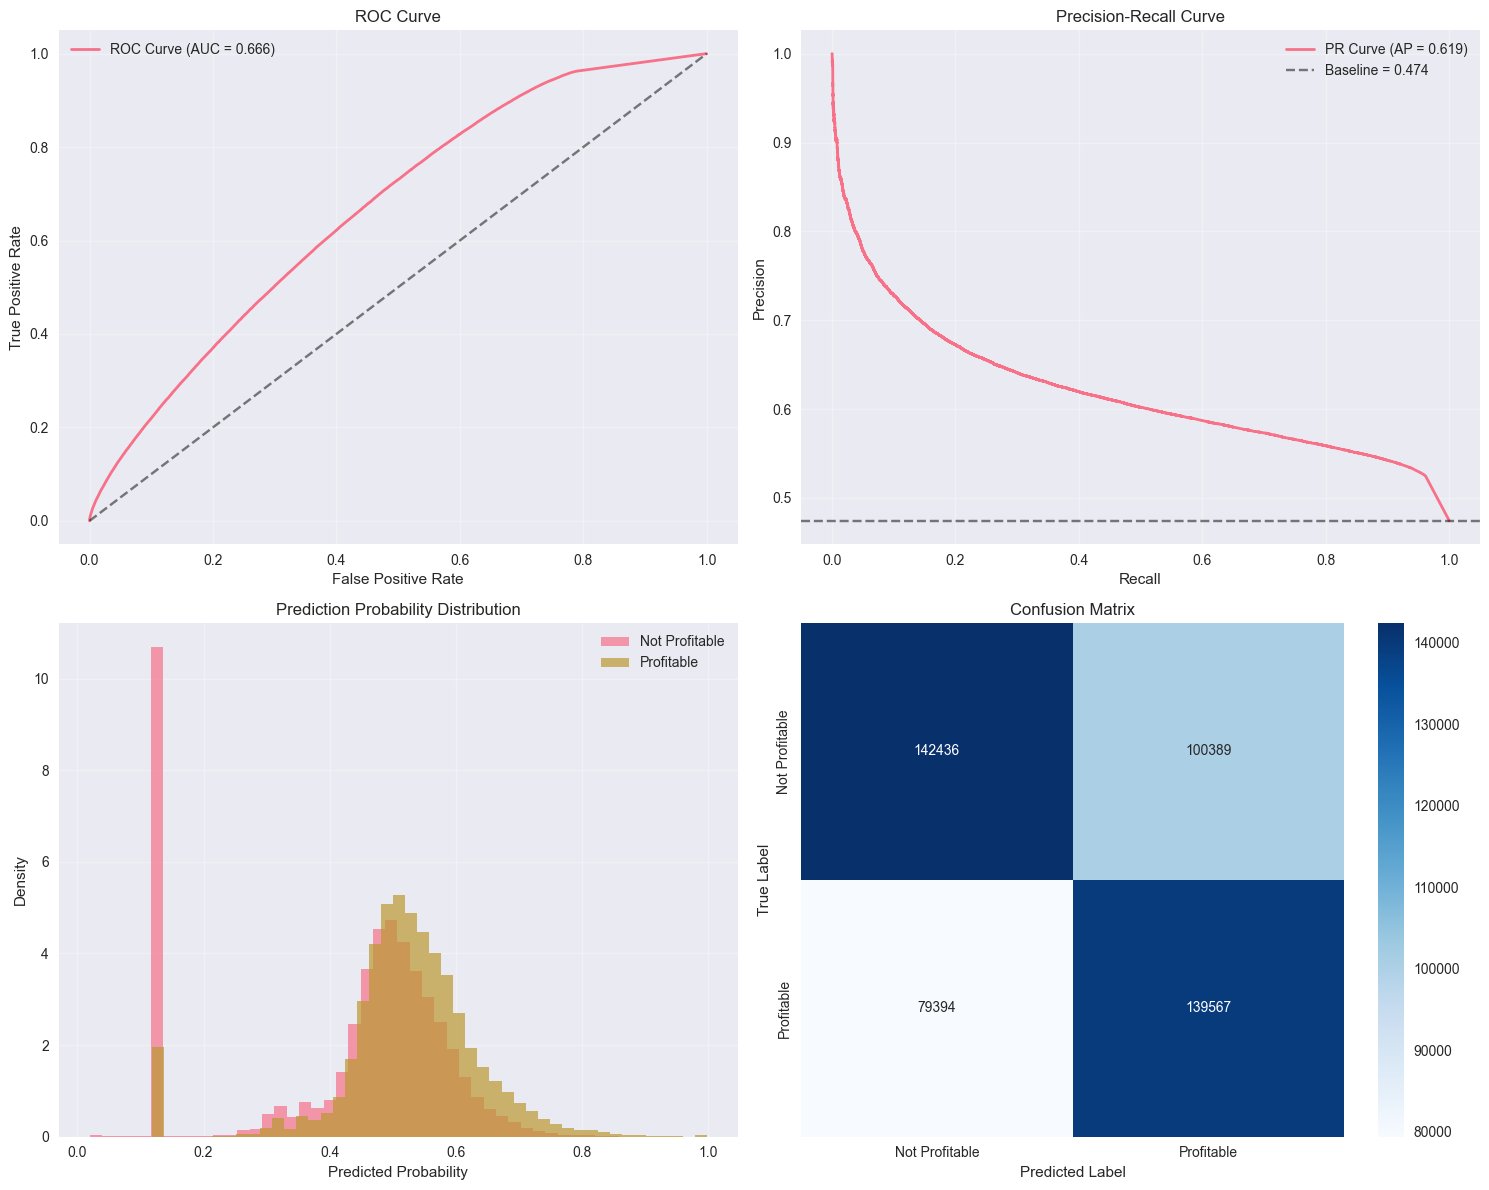

📈 ROC-AUC: 0.6661
📊 Average Precision: 0.6192
🎯 Baseline Precision: 0.4742


In [7]:
# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)

# Create ROC and PR plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
axes[0,0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[0,1].plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {avg_precision:.3f})')
baseline_precision = y_test.mean()
axes[0,1].axhline(y=baseline_precision, color='k', linestyle='--', alpha=0.5, 
                  label=f'Baseline = {baseline_precision:.3f}')
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Prediction probability distribution
axes[1,0].hist(y_prob[y_test==0], bins=50, alpha=0.7, label='Not Profitable', density=True)
axes[1,0].hist(y_prob[y_test==1], bins=50, alpha=0.7, label='Profitable', density=True)
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Prediction Probability Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1],
            xticklabels=['Not Profitable', 'Profitable'],
            yticklabels=['Not Profitable', 'Profitable'])
axes[1,1].set_title('Confusion Matrix')
axes[1,1].set_ylabel('True Label')
axes[1,1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print(f"📈 ROC-AUC: {auc_score:.4f}")
print(f"📊 Average Precision: {avg_precision:.4f}")
print(f"🎯 Baseline Precision: {baseline_precision:.4f}")

## 4. Feature Importance Analysis

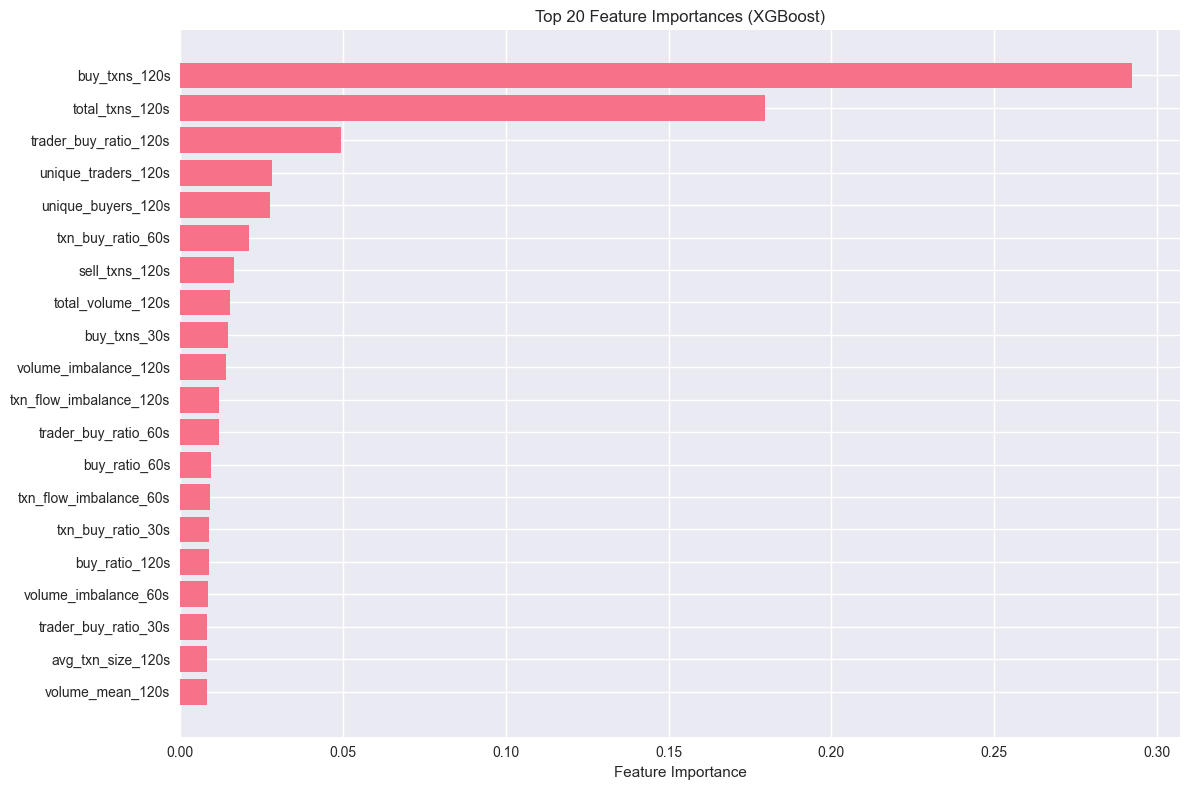

🔝 TOP 15 MOST IMPORTANT FEATURES
buy_txns_120s                                 0.2924
total_txns_120s                               0.1796
trader_buy_ratio_120s                         0.0493
unique_traders_120s                           0.0284
unique_buyers_120s                            0.0277
txn_buy_ratio_60s                             0.0210
sell_txns_120s                                0.0166
total_volume_120s                             0.0154
buy_txns_30s                                  0.0146
volume_imbalance_120s                         0.0142
txn_flow_imbalance_120s                       0.0119
trader_buy_ratio_60s                          0.0119
buy_ratio_60s                                 0.0097
txn_flow_imbalance_60s                        0.0093
txn_buy_ratio_30s                             0.0090

📊 FEATURE IMPORTANCE BY TYPE
Volume       Count:  24, Avg: 0.0061, Total: 0.1471
Ratio        Count:  24, Avg: 0.0207, Total: 0.4978
Trader       Count:   9, Avg: 0.0104, 

In [8]:
# Get feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("🔝 TOP 15 MOST IMPORTANT FEATURES")
print("=" * 60)
for i, row in importance_df.head(15).iterrows():
    print(f"{row['feature']:<45} {row['importance']:.4f}")

# Analyze feature importance by type
print("\n📊 FEATURE IMPORTANCE BY TYPE")
print("=" * 40)

# Group features by type (based on naming convention)
feature_types = {
    'volume': [],
    'ratio': [],
    'trader': [],
    'temporal': [],
    'price': [],
    'other': []
}

for _, row in importance_df.iterrows():
    feature = row['feature']
    importance = row['importance']
    
    if 'volume' in feature.lower():
        feature_types['volume'].append(importance)
    elif 'ratio' in feature.lower() or 'buy_' in feature.lower():
        feature_types['ratio'].append(importance)
    elif 'trader' in feature.lower() or 'unique' in feature.lower():
        feature_types['trader'].append(importance)
    elif any(x in feature.lower() for x in ['time', 'hour', 'day', 'temporal']):
        feature_types['temporal'].append(importance)
    elif 'price' in feature.lower():
        feature_types['price'].append(importance)
    else:
        feature_types['other'].append(importance)

for feature_type, importances in feature_types.items():
    if importances:
        avg_importance = np.mean(importances)
        total_importance = np.sum(importances)
        count = len(importances)
        print(f"{feature_type.capitalize():<12} Count: {count:3d}, Avg: {avg_importance:.4f}, Total: {total_importance:.4f}")

## 5. SHAP Analysis for Model Interpretability

🔍 Computing SHAP values for model interpretability...
   (Using sample of 1000 test instances for performance)
✅ SHAP values computed for 1000 samples


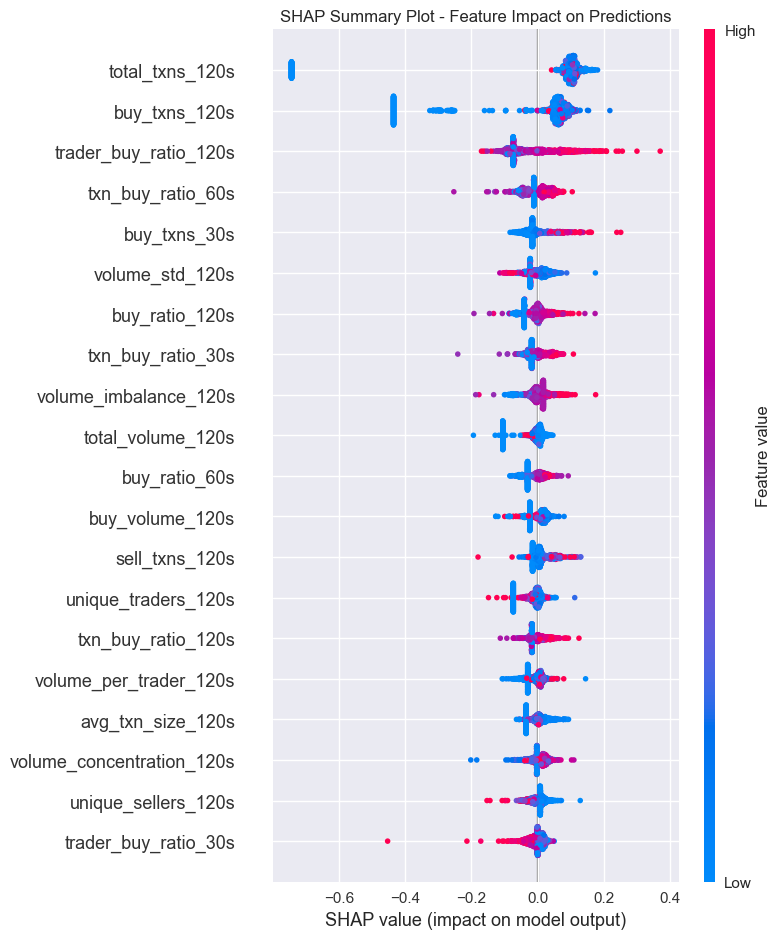

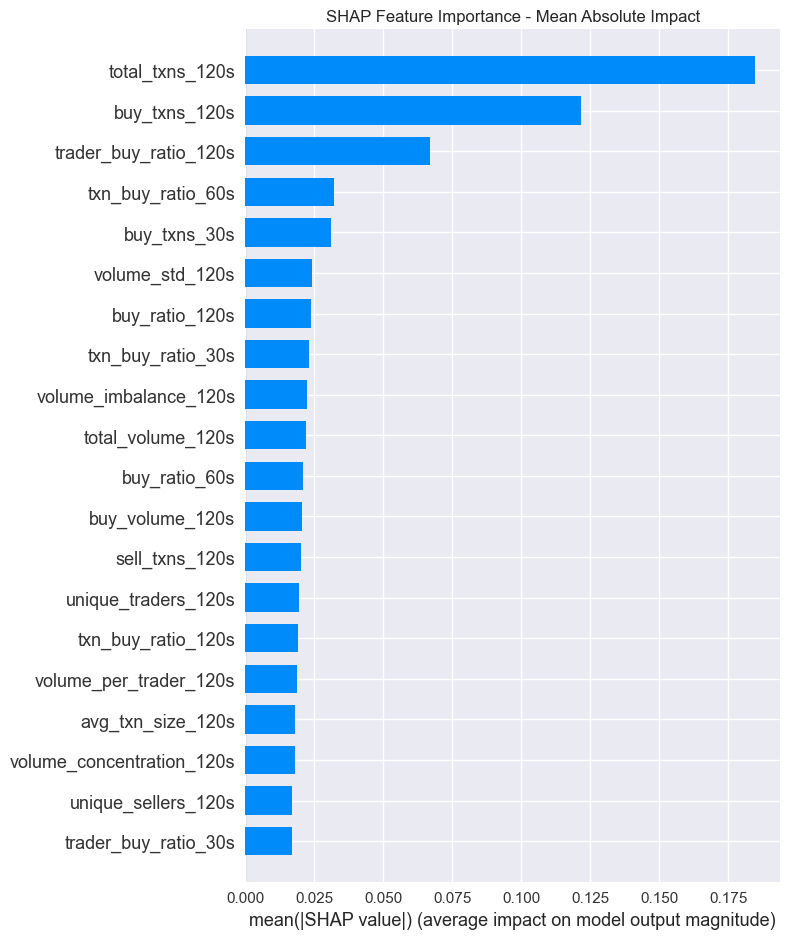


🎯 TOP 15 FEATURES BY SHAP IMPORTANCE
total_txns_120s                               0.1845
buy_txns_120s                                 0.1217
trader_buy_ratio_120s                         0.0668
txn_buy_ratio_60s                             0.0322
buy_txns_30s                                  0.0309
volume_std_120s                               0.0242
buy_ratio_120s                                0.0237
txn_buy_ratio_30s                             0.0231
volume_imbalance_120s                         0.0224
total_volume_120s                             0.0221
buy_ratio_60s                                 0.0209
buy_volume_120s                               0.0205
sell_txns_120s                                0.0201
unique_traders_120s                           0.0193
txn_buy_ratio_120s                            0.0193


In [9]:
# SHAP analysis (sample subset for performance)
print("🔍 Computing SHAP values for model interpretability...")
print("   (Using sample of 1000 test instances for performance)")

# Sample subset for SHAP analysis
sample_size = min(1000, len(X_test))
sample_idx = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test.iloc[sample_idx]
y_sample = y_test.iloc[sample_idx]

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(f"✅ SHAP values computed for {sample_size} samples")

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False, max_display=20)
plt.title('SHAP Summary Plot - Feature Impact on Predictions')
plt.tight_layout()
plt.show()

# SHAP feature importance
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                  plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance - Mean Absolute Impact')
plt.tight_layout()
plt.show()

# Calculate mean absolute SHAP values
mean_shap_values = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': mean_shap_values
}).sort_values('shap_importance', ascending=False)

print("\n🎯 TOP 15 FEATURES BY SHAP IMPORTANCE")
print("=" * 60)
for i, row in shap_importance_df.head(15).iterrows():
    print(f"{row['feature']:<45} {row['shap_importance']:.4f}")

## 6. Threshold Optimization for Trading Strategy

🎯 THRESHOLD OPTIMIZATION FOR TRADING STRATEGY


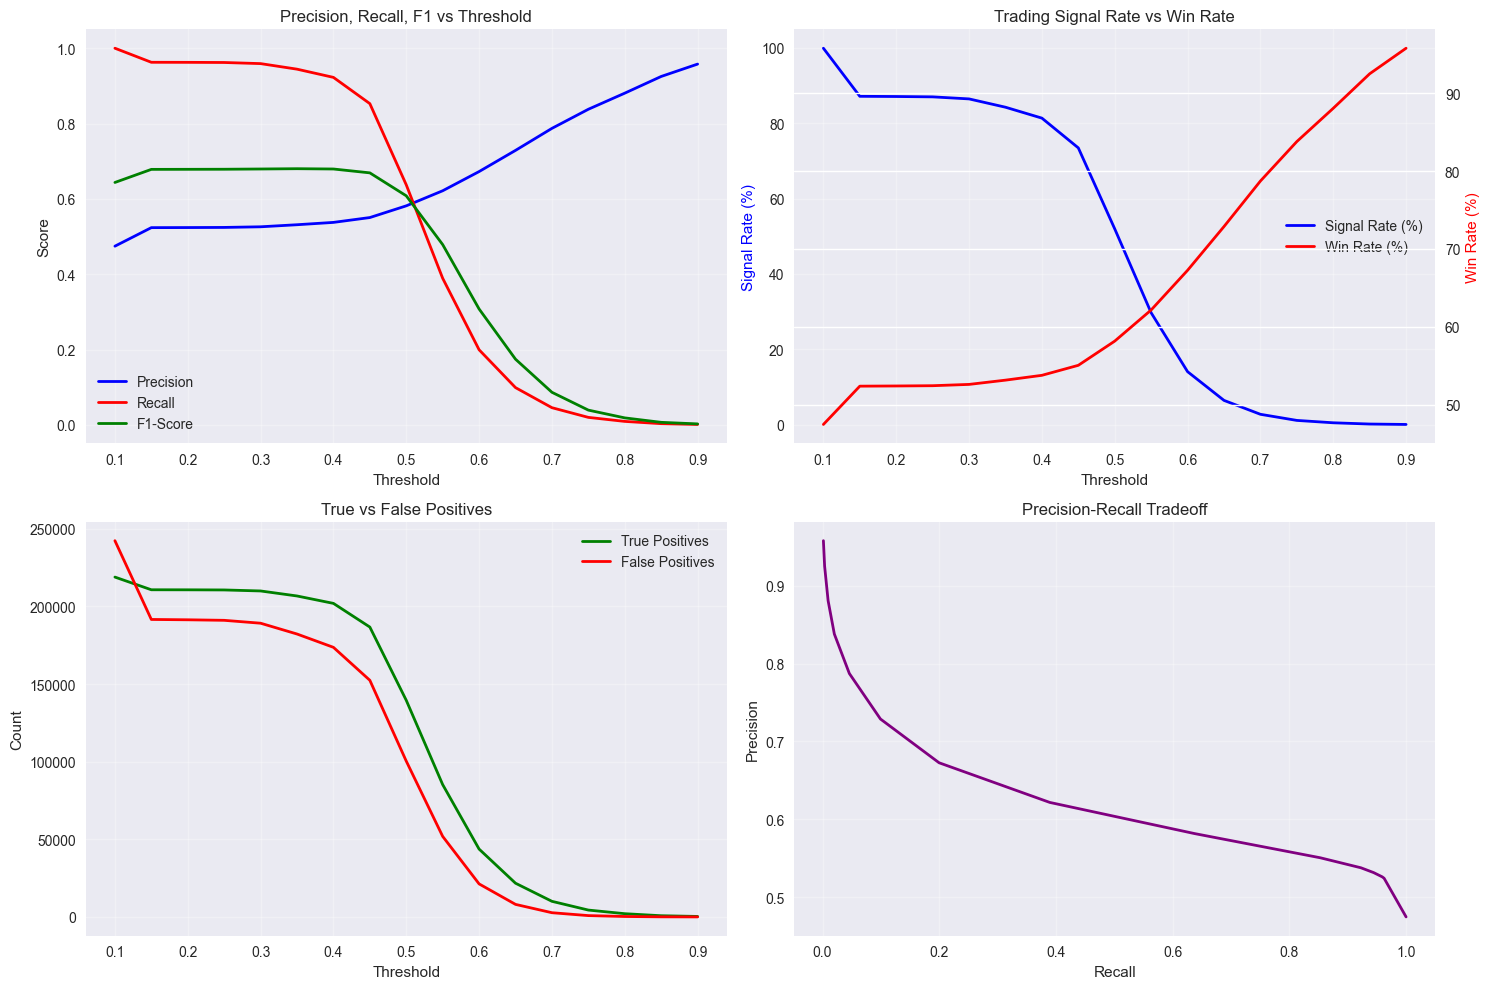


🎯 OPTIMAL THRESHOLDS FOR DIFFERENT CRITERIA
Best F1 Score:     Threshold = 0.35, F1 = 0.680
                   Precision = 0.531, Recall = 0.944
                   Signal Rate = 84.2%, Win Rate = 53.1%

High Precision:    Threshold = 0.60, Precision = 0.673
                   Recall = 0.200, F1 = 0.308
                   Signal Rate = 14.1%, Win Rate = 67.3%

Balanced Trading:  Threshold = 0.65, Win Rate = 72.9%
                   Precision = 0.729, Recall = 0.099
                   Signal Rate = 6.5%, F1 = 0.175


In [10]:
# Analyze different probability thresholds for trading strategy
print("🎯 THRESHOLD OPTIMIZATION FOR TRADING STRATEGY")
print("=" * 60)

thresholds = np.arange(0.1, 0.95, 0.05)
threshold_results = []

for threshold in thresholds:
    # Apply threshold
    y_pred_thresh = (y_prob >= threshold).astype(int)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred_thresh)
    
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Trading-specific metrics
        signal_rate = (tp + fp) / len(y_test)  # Fraction of time we'd be trading
        win_rate = tp / (tp + fp) if (tp + fp) > 0 else 0  # Win rate when trading
        
        threshold_results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'signal_rate': signal_rate,
            'win_rate': win_rate,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn
        })

threshold_df = pd.DataFrame(threshold_results)

# Plot threshold analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Precision vs Recall
axes[0,0].plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
axes[0,0].plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall', linewidth=2)
axes[0,0].plot(threshold_df['threshold'], threshold_df['f1'], 'g-', label='F1-Score', linewidth=2)
axes[0,0].set_xlabel('Threshold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Precision, Recall, F1 vs Threshold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Signal Rate and Win Rate
ax1 = axes[0,1]
ax2 = ax1.twinx()

line1 = ax1.plot(threshold_df['threshold'], threshold_df['signal_rate'] * 100, 'b-', 
                 label='Signal Rate (%)', linewidth=2)
line2 = ax2.plot(threshold_df['threshold'], threshold_df['win_rate'] * 100, 'r-', 
                 label='Win Rate (%)', linewidth=2)

ax1.set_xlabel('Threshold')
ax1.set_ylabel('Signal Rate (%)', color='b')
ax2.set_ylabel('Win Rate (%)', color='r')
ax1.set_title('Trading Signal Rate vs Win Rate')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')
ax1.grid(True, alpha=0.3)

# True/False Positives
axes[1,0].plot(threshold_df['threshold'], threshold_df['tp'], 'g-', label='True Positives', linewidth=2)
axes[1,0].plot(threshold_df['threshold'], threshold_df['fp'], 'r-', label='False Positives', linewidth=2)
axes[1,0].set_xlabel('Threshold')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('True vs False Positives')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Precision-Recall tradeoff
axes[1,1].plot(threshold_df['recall'], threshold_df['precision'], 'purple', linewidth=2)
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Tradeoff')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal thresholds for different criteria
print("\n🎯 OPTIMAL THRESHOLDS FOR DIFFERENT CRITERIA")
print("=" * 50)

# Best F1 score
best_f1_idx = threshold_df['f1'].idxmax()
best_f1_row = threshold_df.iloc[best_f1_idx]
print(f"Best F1 Score:     Threshold = {best_f1_row['threshold']:.2f}, F1 = {best_f1_row['f1']:.3f}")
print(f"                   Precision = {best_f1_row['precision']:.3f}, Recall = {best_f1_row['recall']:.3f}")
print(f"                   Signal Rate = {best_f1_row['signal_rate']*100:.1f}%, Win Rate = {best_f1_row['win_rate']*100:.1f}%")

# High precision (good for trading)
high_precision_mask = threshold_df['precision'] >= 0.65
if high_precision_mask.any():
    high_prec_options = threshold_df[high_precision_mask]
    best_high_prec_idx = high_prec_options['recall'].idxmax()
    best_high_prec_row = threshold_df.iloc[best_high_prec_idx]
    print(f"\nHigh Precision:    Threshold = {best_high_prec_row['threshold']:.2f}, Precision = {best_high_prec_row['precision']:.3f}")
    print(f"                   Recall = {best_high_prec_row['recall']:.3f}, F1 = {best_high_prec_row['f1']:.3f}")
    print(f"                   Signal Rate = {best_high_prec_row['signal_rate']*100:.1f}%, Win Rate = {best_high_prec_row['win_rate']*100:.1f}%")

# Balanced signal rate (5-15% of time trading)
balanced_signal_mask = (threshold_df['signal_rate'] >= 0.05) & (threshold_df['signal_rate'] <= 0.15)
if balanced_signal_mask.any():
    balanced_options = threshold_df[balanced_signal_mask]
    best_balanced_idx = balanced_options['win_rate'].idxmax()
    best_balanced_row = threshold_df.iloc[best_balanced_idx]
    print(f"\nBalanced Trading:  Threshold = {best_balanced_row['threshold']:.2f}, Win Rate = {best_balanced_row['win_rate']*100:.1f}%")
    print(f"                   Precision = {best_balanced_row['precision']:.3f}, Recall = {best_balanced_row['recall']:.3f}")
    print(f"                   Signal Rate = {best_balanced_row['signal_rate']*100:.1f}%, F1 = {best_balanced_row['f1']:.3f}")

## 7. Error Analysis and Model Insights

🔍 ERROR ANALYSIS
True Positives:  139,567 (30.2%)
False Positives: 100,389 (21.7%)
True Negatives:  142,436 (30.8%)
False Negatives: 79,394 (17.2%)

True Positives:
  Mean confidence: 0.584
  Std confidence:  0.071
  Min confidence:  0.500
  Max confidence:  0.997

False Positives:
  Mean confidence: 0.565
  Std confidence:  0.054
  Min confidence:  0.500
  Max confidence:  0.996

True Negatives:
  Mean confidence: 0.329
  Std confidence:  0.153
  Min confidence:  0.019
  Max confidence:  0.500

False Negatives:
  Mean confidence: 0.419
  Std confidence:  0.106
  Min confidence:  0.041
  Max confidence:  0.500


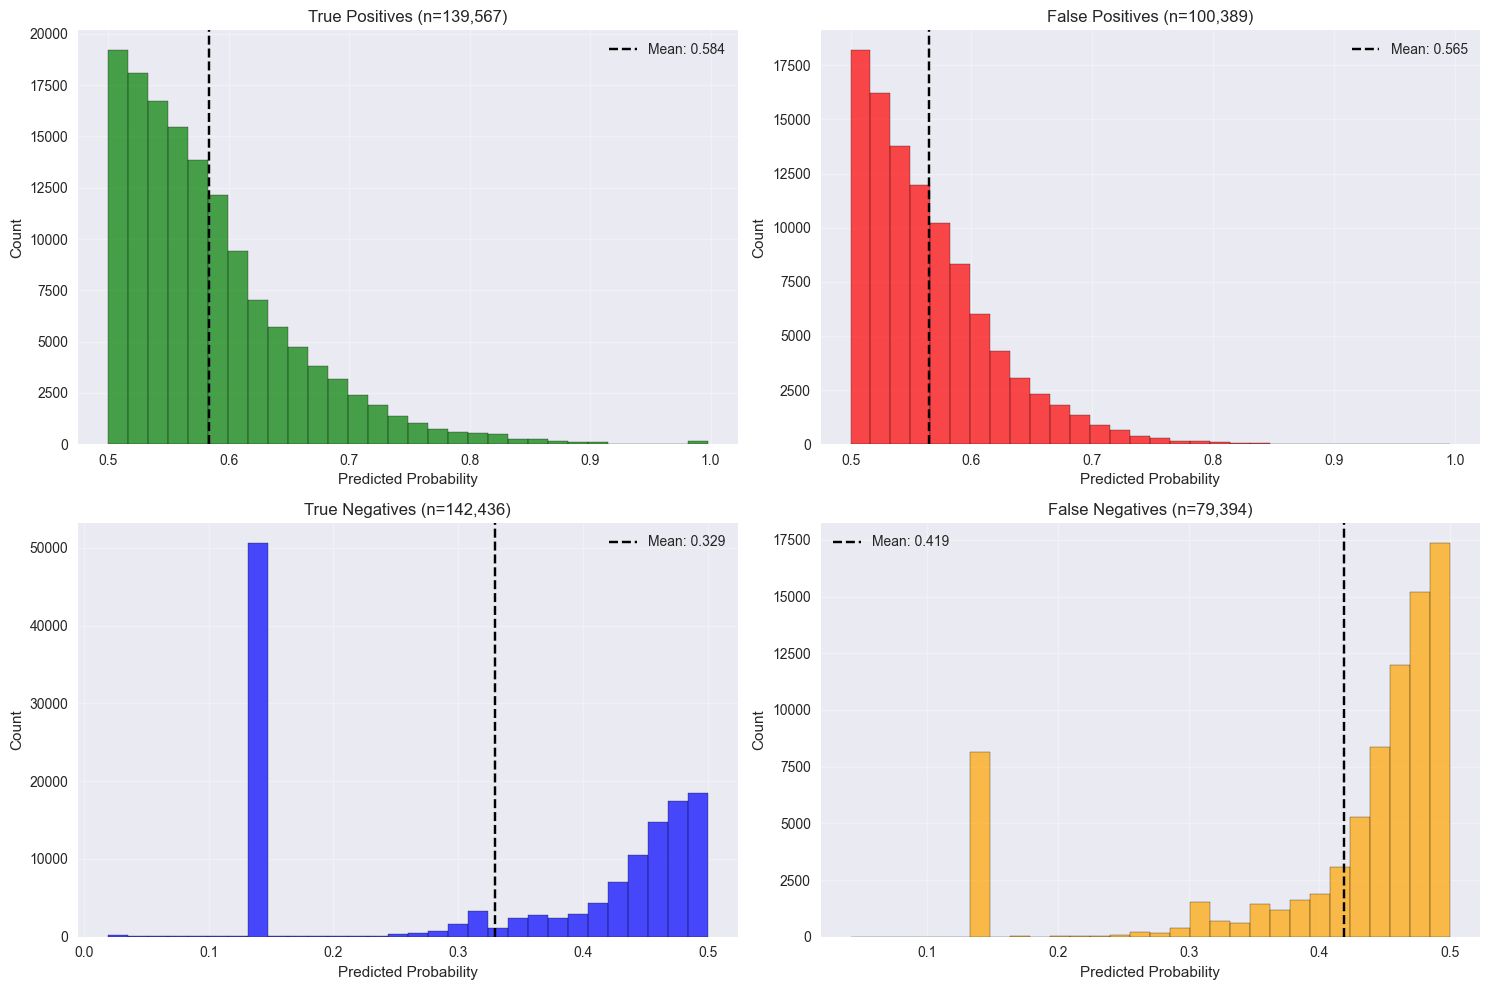


🎯 CONFIDENCE ANALYSIS
High Confidence Positive (≥0.8): 2,372 samples
  Accuracy: 0.881 (88.1%)
High Confidence Negative (≤0.2): 59,610 samples
  Accuracy: 0.862 (86.2%)
Uncertain (0.2-0.8): 399,804 samples
  Positive rate: 0.522 (52.2%)


In [11]:
# Analyze prediction errors
print("🔍 ERROR ANALYSIS")
print("=" * 40)

# Using default threshold (0.5)
y_pred_default = (y_prob >= 0.5).astype(int)

# Identify different types of predictions
true_positives = (y_test == 1) & (y_pred_default == 1)
false_positives = (y_test == 0) & (y_pred_default == 1)
true_negatives = (y_test == 0) & (y_pred_default == 0)
false_negatives = (y_test == 1) & (y_pred_default == 0)

print(f"True Positives:  {true_positives.sum():,} ({true_positives.mean()*100:.1f}%)")
print(f"False Positives: {false_positives.sum():,} ({false_positives.mean()*100:.1f}%)")
print(f"True Negatives:  {true_negatives.sum():,} ({true_negatives.mean()*100:.1f}%)")
print(f"False Negatives: {false_negatives.sum():,} ({false_negatives.mean()*100:.1f}%)")

# Analyze prediction confidence for different outcomes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Confidence distribution by outcome
outcomes = {
    'True Positives': y_prob[true_positives],
    'False Positives': y_prob[false_positives],
    'True Negatives': y_prob[true_negatives],
    'False Negatives': y_prob[false_negatives]
}

colors = ['green', 'red', 'blue', 'orange']
for i, (outcome, probs) in enumerate(outcomes.items()):
    if len(probs) > 0:
        axes[i//2, i%2].hist(probs, bins=30, alpha=0.7, color=colors[i], edgecolor='black')
        axes[i//2, i%2].axvline(probs.mean(), color='black', linestyle='--', 
                               label=f'Mean: {probs.mean():.3f}')
        axes[i//2, i%2].set_title(f'{outcome} (n={len(probs):,})')
        axes[i//2, i%2].set_xlabel('Predicted Probability')
        axes[i//2, i%2].set_ylabel('Count')
        axes[i//2, i%2].legend()
        axes[i//2, i%2].grid(True, alpha=0.3)
        
        print(f"\n{outcome}:")
        print(f"  Mean confidence: {probs.mean():.3f}")
        print(f"  Std confidence:  {probs.std():.3f}")
        print(f"  Min confidence:  {probs.min():.3f}")
        print(f"  Max confidence:  {probs.max():.3f}")

plt.tight_layout()
plt.show()

# High confidence predictions analysis
high_conf_threshold = 0.8
low_conf_threshold = 0.2

high_conf_positive = y_prob >= high_conf_threshold
high_conf_negative = y_prob <= low_conf_threshold
uncertain = (y_prob > low_conf_threshold) & (y_prob < high_conf_threshold)

print(f"\n🎯 CONFIDENCE ANALYSIS")
print(f"{'='*40}")
print(f"High Confidence Positive (≥{high_conf_threshold}): {high_conf_positive.sum():,} samples")
if high_conf_positive.sum() > 0:
    hcp_accuracy = (y_test[high_conf_positive] == 1).mean()
    print(f"  Accuracy: {hcp_accuracy:.3f} ({hcp_accuracy*100:.1f}%)")

print(f"High Confidence Negative (≤{low_conf_threshold}): {high_conf_negative.sum():,} samples")
if high_conf_negative.sum() > 0:
    hcn_accuracy = (y_test[high_conf_negative] == 0).mean()
    print(f"  Accuracy: {hcn_accuracy:.3f} ({hcn_accuracy*100:.1f}%)")

print(f"Uncertain ({low_conf_threshold}-{high_conf_threshold}): {uncertain.sum():,} samples")
if uncertain.sum() > 0:
    unc_pos_rate = y_test[uncertain].mean()
    print(f"  Positive rate: {unc_pos_rate:.3f} ({unc_pos_rate*100:.1f}%)")

In [12]:
# Load forward volume data and calculate actual profits at different thresholds
print("💰 PROFIT ANALYSIS USING FORWARD VOLUME DATA")
print("=" * 60)

# Get forward volume data from test set
forward_buy = test_data['forward_buy_volume_300s_val']
forward_sell = test_data['forward_sell_volume_300s_val']

# Calculate actual profit/loss for each sample
actual_pnl = forward_buy - forward_sell

print(f"Forward volume data loaded:")
print(f"  Buy volume range: ${forward_buy.min():.2f} - ${forward_buy.max():.2f}")
print(f"  Sell volume range: ${forward_sell.min():.2f} - ${forward_sell.max():.2f}")
print(f"  Actual P&L range: ${actual_pnl.min():.2f} - ${actual_pnl.max():.2f}")
print(f"  Mean P&L: ${actual_pnl.mean():.4f}")

# Analyze profits at different probability thresholds
thresholds = np.arange(0.1, 0.95, 0.05)
profit_results = []

for threshold in thresholds:
    # Get predictions at this threshold
    predictions = (y_prob >= threshold).astype(int)
    
    # Calculate profits for trades we would take (positive predictions)
    trade_mask = predictions == 1
    
    if trade_mask.sum() > 0:
        # P&L for trades we would take
        trades_pnl = actual_pnl[trade_mask]
        
        # Calculate metrics
        total_trades = trade_mask.sum()
        avg_profit = trades_pnl.mean()
        total_profit = trades_pnl.sum()
        win_rate = (trades_pnl > 0).mean()
        avg_win = trades_pnl[trades_pnl > 0].mean() if (trades_pnl > 0).any() else 0
        avg_loss = trades_pnl[trades_pnl <= 0].mean() if (trades_pnl <= 0).any() else 0
        profit_factor = abs(trades_pnl[trades_pnl > 0].sum() / trades_pnl[trades_pnl <= 0].sum()) if (trades_pnl <= 0).any() else np.inf
        
        profit_results.append({
            'threshold': threshold,
            'total_trades': total_trades,
            'trade_rate': total_trades / len(y_test),
            'avg_profit': avg_profit,
            'total_profit': total_profit,
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor if not np.isinf(profit_factor) else 0,
            'sharpe_ratio': avg_profit / trades_pnl.std() if trades_pnl.std() > 0 else 0
        })

profit_df = pd.DataFrame(profit_results)

# Display results table
print(f"\n📊 PROFIT ANALYSIS BY THRESHOLD")
print("=" * 100)
print(f"{'Threshold':<10} {'Trades':<8} {'Rate%':<8} {'Avg P&L':<10} {'Total P&L':<12} {'Win%':<8} {'Avg Win':<10} {'Avg Loss':<10} {'PF':<6}")
print("-" * 100)

for _, row in profit_df.iterrows():
    print(f"{row['threshold']:<10.2f} {row['total_trades']:<8.0f} {row['trade_rate']*100:<8.1f} "
          f"${row['avg_profit']:<9.4f} ${row['total_profit']:<11.2f} {row['win_rate']*100:<8.1f} "
          f"${row['avg_win']:<9.4f} ${row['avg_loss']:<9.4f} {row['profit_factor']:<6.2f}")

# Find optimal thresholds
best_avg_profit_idx = profit_df['avg_profit'].idxmax()
best_total_profit_idx = profit_df['total_profit'].idxmax()
best_sharpe_idx = profit_df['sharpe_ratio'].idxmax()

print(f"\n🎯 OPTIMAL THRESHOLDS")
print("=" * 50)
print(f"Best Average Profit: {profit_df.iloc[best_avg_profit_idx]['threshold']:.2f} "
      f"(${profit_df.iloc[best_avg_profit_idx]['avg_profit']:.4f} per trade)")
print(f"Best Total Profit:   {profit_df.iloc[best_total_profit_idx]['threshold']:.2f} "
      f"(${profit_df.iloc[best_total_profit_idx]['total_profit']:.2f} total)")
print(f"Best Sharpe Ratio:   {profit_df.iloc[best_sharpe_idx]['threshold']:.2f} "
      f"({profit_df.iloc[best_sharpe_idx]['sharpe_ratio']:.3f} ratio)")

💰 PROFIT ANALYSIS USING FORWARD VOLUME DATA
Forward volume data loaded:
  Buy volume range: $0.00 - $157199.58
  Sell volume range: $0.00 - $163080.75
  Actual P&L range: $-40251.60 - $98733.92
  Mean P&L: $5.8125

📊 PROFIT ANALYSIS BY THRESHOLD
Threshold  Trades   Rate%    Avg P&L    Total P&L    Win%     Avg Win    Avg Loss   PF    
----------------------------------------------------------------------------------------------------
0.10       461347   99.9     $6.0245    $2779366.47  47.5     $85.6023   $-65.8552  1.17  
0.15       402424   87.1     $6.6478    $2675219.11  52.4     $88.0061   $-82.8307  1.17  
0.20       402176   87.1     $6.7789    $2726306.11  52.4     $88.0166   $-82.6524  1.17  
0.25       401745   87.0     $6.8931    $2769255.56  52.4     $88.0001   $-82.5182  1.18  
0.30       399236   86.5     $7.2345    $2888259.99  52.6     $87.8963   $-82.2835  1.19  
0.35       389051   84.2     $8.3945    $3265885.63  53.1     $87.6532   $-81.5199  1.22  
0.40       37569

## 8. Time Since First Trade Analysis

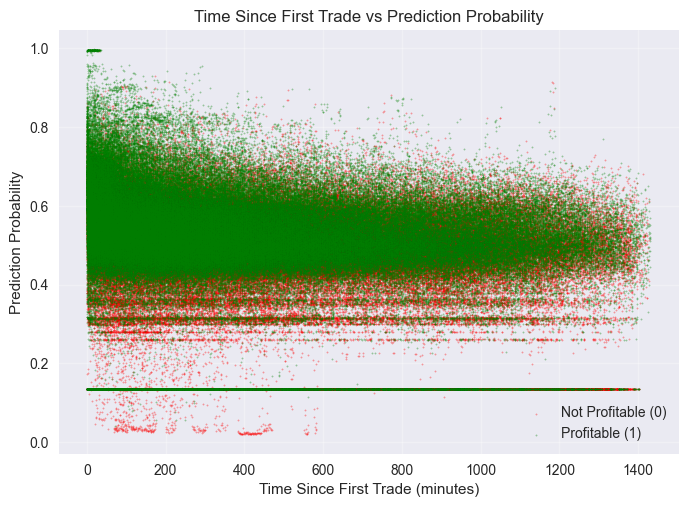

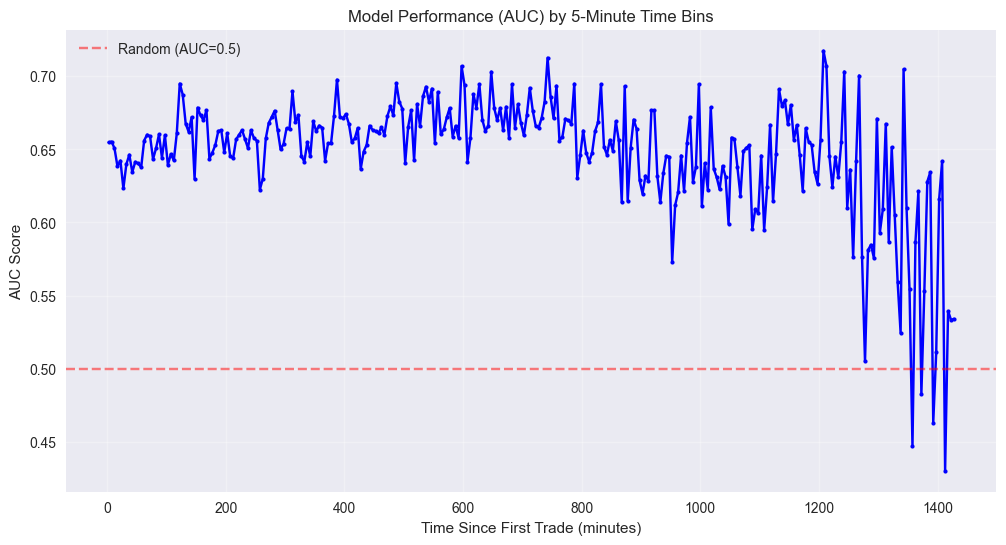

Total bins: 287
Bins with valid AUC: 286
AUC range: 0.430 - 0.717


In [14]:
# Plot not profitable (0) in red
plt.scatter(time_since_first_trade_minutes[y_test == 0],
             y_prob[y_test == 0],
             c='red', alpha=0.3, s=1, label='Not Profitable (0)')

  # Plot profitable (1) in green  
plt.scatter(time_since_first_trade_minutes[y_test == 1],
             y_prob[y_test == 1],
             c='green', alpha=0.3, s=1, label='Profitable (1)')

plt.xlabel('Time Since First Trade (minutes)')
plt.ylabel('Prediction Probability')
plt.title('Time Since First Trade vs Prediction Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

max_time = time_since_first_trade_minutes.max()
bins = np.arange(0, max_time + 5, 5)  # 5-minute bins
bin_centers = bins[:-1] + 2.5  # Center of each bin

  # Calculate AUC for each bin
auc_scores = []
bin_counts = []

for i in range(len(bins) - 1):
      mask = (time_since_first_trade_minutes >= bins[i]) & (time_since_first_trade_minutes < bins[i + 1])

      if mask.sum() > 0:
          bin_y = y_test[mask]
          bin_prob = y_prob[mask]

          # Only calculate AUC if we have both classes
          if len(np.unique(bin_y)) > 1:
              auc = roc_auc_score(bin_y, bin_prob)
          else:
              auc = np.nan

          auc_scores.append(auc)
          bin_counts.append(mask.sum())
      else:
          auc_scores.append(np.nan)
          bin_counts.append(0)

  # Plot AUC vs time bins
plt.figure(figsize=(12, 6))
valid_mask = ~np.isnan(auc_scores)
plt.plot(bin_centers[valid_mask], np.array(auc_scores)[valid_mask], 'b-o', markersize=3)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random (AUC=0.5)')
plt.xlabel('Time Since First Trade (minutes)')
plt.ylabel('AUC Score')
plt.title('Model Performance (AUC) by 5-Minute Time Bins')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total bins: {len(bins)-1}")
print(f"Bins with valid AUC: {valid_mask.sum()}")
print(f"AUC range: {np.nanmin(auc_scores):.3f} - {np.nanmax(auc_scores):.3f}")

## 9. Regime segment and analysis

In [16]:
CLUSTERING_DIR = "/Volumes/Extreme SSD/trading_data/solana/models/regime_clustering"
import joblib
regime_classifier = joblib.load(f"{CLUSTERING_DIR}/regime_classifier.pkl")
scaler = joblib.load(f"{CLUSTERING_DIR}/feature_scaler.pkl")
feature_names = joblib.load(f"{CLUSTERING_DIR}/feature_names.pkl")

X_scaled = scaler.transform(X_test)
regime_labels = regime_classifier.predict(X_scaled)

📊 MODEL PERFORMANCE BY REGIME

📋 REGIME PERFORMANCE SUMMARY
Regime   Count    Samples %  Profit Rate  Avg Pred   AUC     
----------------------------------------------------------------------
0.0      314,006.0 68.0       0.533        0.532      0.583   
1.0      108,209.0 23.4       0.262        0.261      0.698   
2.0      39,571.0 8.6        0.587        0.585      0.665   


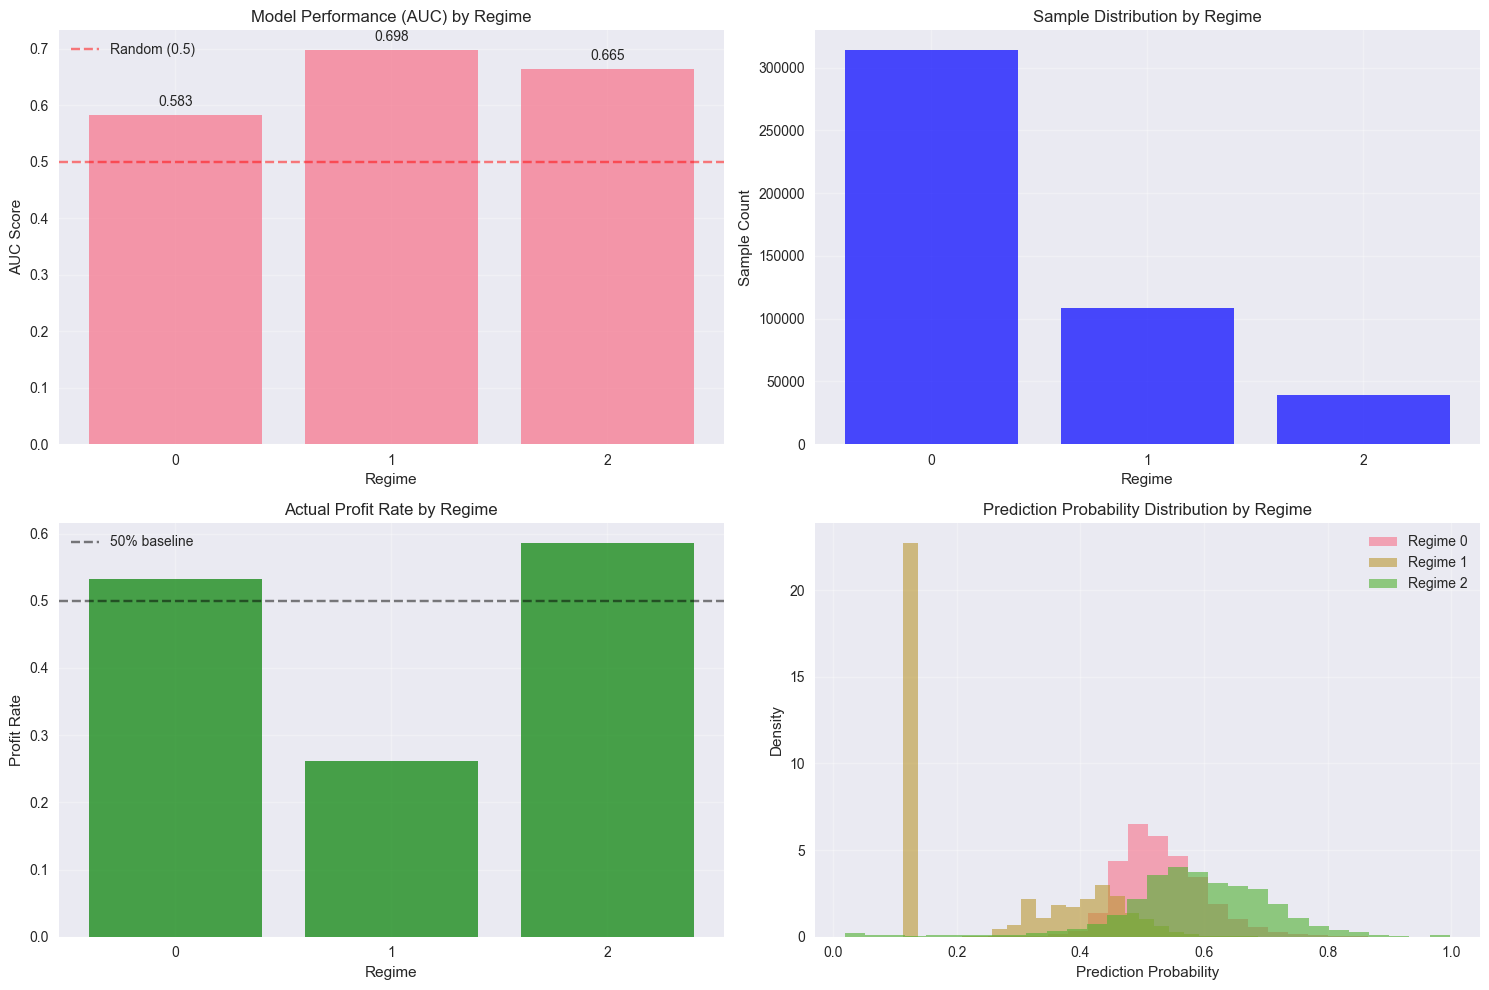


🔍 REGIME PERFORMANCE INSIGHTS:
   Best performing regime: 1.0 (AUC: 0.698)
   Worst performing regime: 0.0 (AUC: 0.583)
   AUC difference: 0.114
   Regime 0.0: Weak model performance, 314,006.0 samples (68.0%)
   Regime 1.0: Good model performance, 108,209.0 samples (23.4%)
   Regime 2.0: Good model performance, 39,571.0 samples (8.6%)


In [17]:
# Analyze model performance by regime labels
print("📊 MODEL PERFORMANCE BY REGIME")
print("=" * 50)

# Calculate AUC by regime
regime_analysis = []
unique_regimes = np.unique(regime_labels)

for regime in unique_regimes:
    regime_mask = regime_labels == regime
    
    if regime_mask.sum() > 0:
        regime_y = y_test[regime_mask]
        regime_prob = y_prob[regime_mask]
        
        # Only calculate AUC if we have both classes
        if len(np.unique(regime_y)) > 1:
            auc = roc_auc_score(regime_y, regime_prob)
        else:
            auc = np.nan
            
        regime_analysis.append({
            'regime': regime,
            'count': regime_mask.sum(),
            'profit_rate': regime_y.mean(),
            'avg_prediction_prob': regime_prob.mean(),
            'auc_score': auc
        })

regime_df = pd.DataFrame(regime_analysis)

print(f"\n📋 REGIME PERFORMANCE SUMMARY")
print("=" * 70)
print(f"{'Regime':<8} {'Count':<8} {'Samples %':<10} {'Profit Rate':<12} {'Avg Pred':<10} {'AUC':<8}")
print("-" * 70)

for _, row in regime_df.iterrows():
    auc_str = f"{row['auc_score']:.3f}" if not pd.isna(row['auc_score']) else "N/A"
    samples_pct = row['count'] / len(y_test) * 100
    print(f"{row['regime']:<8} {row['count']:<8,} {samples_pct:<10.1f} "
          f"{row['profit_rate']:<12.3f} {row['avg_prediction_prob']:<10.3f} {auc_str:<8}")

# Plot regime analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. AUC by regime
valid_aucs = regime_df.dropna(subset=['auc_score'])
if not valid_aucs.empty:
    bars = axes[0,0].bar(valid_aucs['regime'].astype(str), valid_aucs['auc_score'], alpha=0.7)
    axes[0,0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random (0.5)')
    axes[0,0].set_xlabel('Regime')
    axes[0,0].set_ylabel('AUC Score')
    axes[0,0].set_title('Model Performance (AUC) by Regime')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, auc in zip(bars, valid_aucs['auc_score']):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{auc:.3f}', ha='center', va='bottom')

# 2. Sample distribution by regime
axes[0,1].bar(regime_df['regime'].astype(str), regime_df['count'], alpha=0.7, color='blue')
axes[0,1].set_xlabel('Regime')
axes[0,1].set_ylabel('Sample Count')
axes[0,1].set_title('Sample Distribution by Regime')
axes[0,1].grid(True, alpha=0.3)

# 3. Profit rate by regime
axes[1,0].bar(regime_df['regime'].astype(str), regime_df['profit_rate'], alpha=0.7, color='green')
axes[1,0].axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='50% baseline')
axes[1,0].set_xlabel('Regime')
axes[1,0].set_ylabel('Profit Rate')
axes[1,0].set_title('Actual Profit Rate by Regime')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Prediction probability distribution by regime
for i, regime in enumerate(unique_regimes):
    regime_mask = regime_labels == regime
    if regime_mask.sum() > 0:
        axes[1,1].hist(y_prob[regime_mask], bins=30, alpha=0.6, 
                      label=f'Regime {regime}', density=True)

axes[1,1].set_xlabel('Prediction Probability')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Prediction Probability Distribution by Regime')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical significance test between regimes
print(f"\n🔍 REGIME PERFORMANCE INSIGHTS:")
if not valid_aucs.empty:
    best_regime = valid_aucs.loc[valid_aucs['auc_score'].idxmax()]
    worst_regime = valid_aucs.loc[valid_aucs['auc_score'].idxmin()]
    
    print(f"   Best performing regime: {best_regime['regime']} (AUC: {best_regime['auc_score']:.3f})")
    print(f"   Worst performing regime: {worst_regime['regime']} (AUC: {worst_regime['auc_score']:.3f})")
    print(f"   AUC difference: {best_regime['auc_score'] - worst_regime['auc_score']:.3f}")
    
    # Show which regimes have significantly different characteristics
    for _, row in regime_df.iterrows():
        if not pd.isna(row['auc_score']):
            performance = "Strong" if row['auc_score'] > 0.7 else "Good" if row['auc_score'] > 0.6 else "Weak"
            print(f"   Regime {row['regime']}: {performance} model performance, {row['count']:,} samples ({row['count']/len(y_test)*100:.1f}%)")

## 10. Model Performance by Regime

💰 PROFIT ANALYSIS BY REGIME (1 & 2) USING FORWARD VOLUME DATA

📊 REGIME 1 PROFIT ANALYSIS
Total samples in regime 1: 108,209
Profit rate: 0.262
Mean P&L: $0.7868

📊 PROFIT ANALYSIS BY THRESHOLD - REGIME 1
Threshold  Trades   Rate%    Avg P&L    Total P&L    Win%     Avg Win    Avg Loss   PF    
----------------------------------------------------------------------------------------------------
0.10       108209   100.0    $0.7868    $85136.43    26.2     $22.6324   $-6.9792   1.15  
0.15       49441    45.7     $-1.1400   $-56363.57   40.9     $22.2285   $-17.3089  0.89  
0.20       49434    45.7     $-1.1429   $-56499.30   40.9     $22.2204   $-17.3107  0.89  
0.25       49321    45.6     $-1.1252   $-55493.94   41.0     $22.0726   $-17.2192  0.89  
0.30       47406    43.8     $-1.0320   $-48924.37   41.6     $22.1359   $-17.5210  0.90  
0.35       38558    35.6     $-0.3642   $-14043.78   43.9     $23.8156   $-19.2499  0.97  
0.40       28786    26.6     $0.8508    $24492.21    46.4

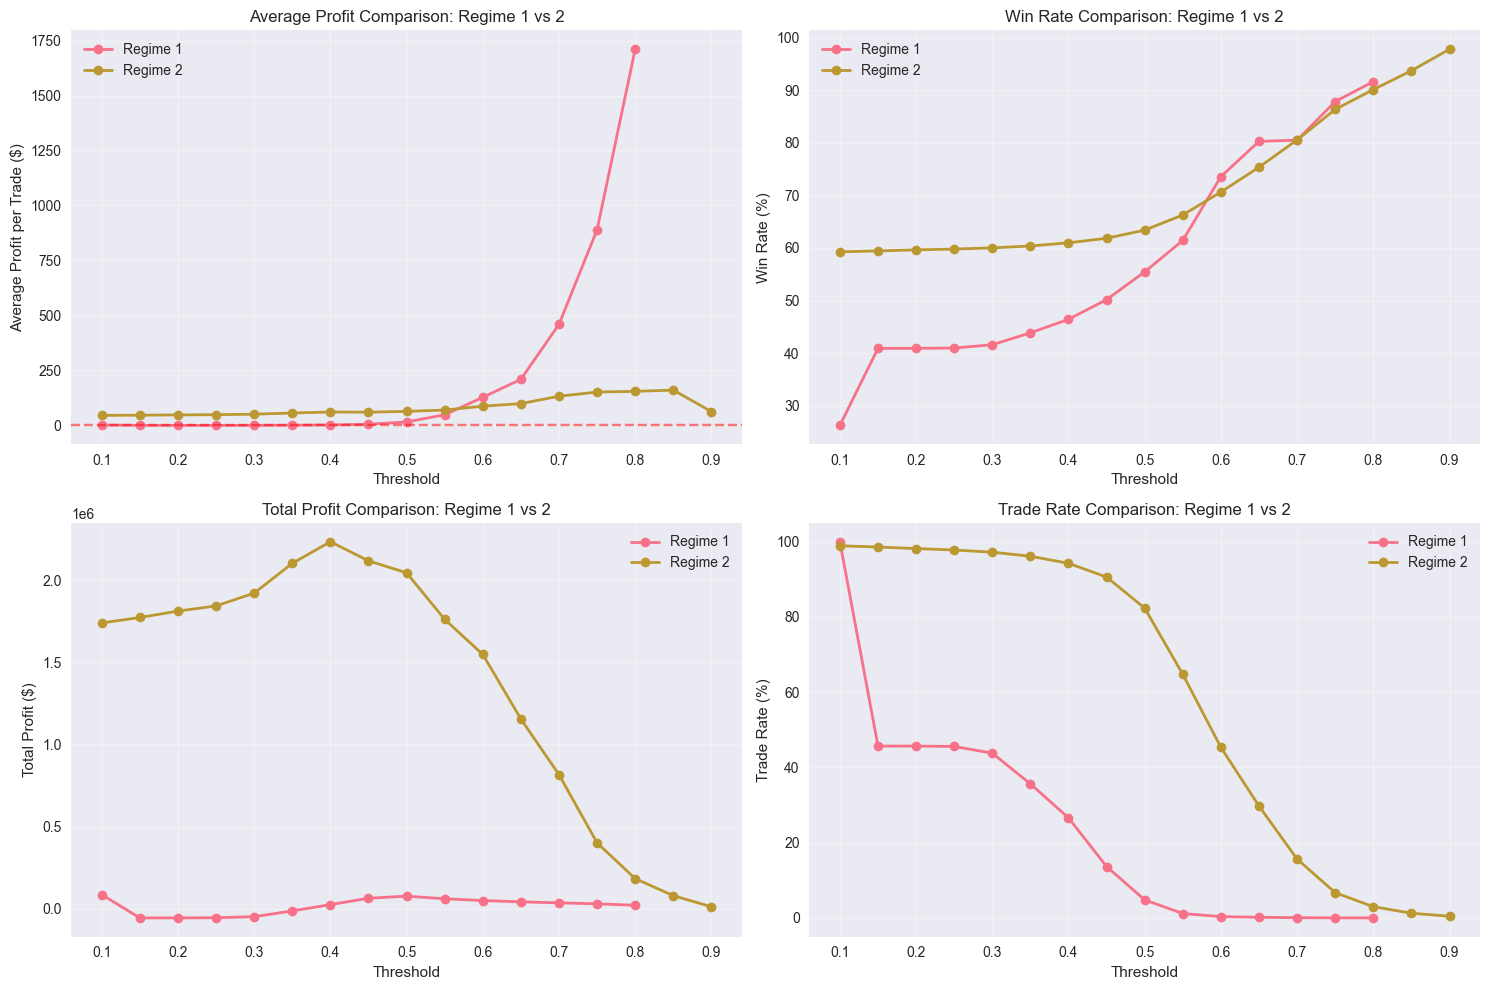

In [19]:
# Profit analysis for specific regimes (1 and 2) using forward volume data
print("💰 PROFIT ANALYSIS BY REGIME (1 & 2) USING FORWARD VOLUME DATA")
print("=" * 70)

# Get forward volume data
forward_buy = test_data['forward_buy_volume_300s_val']
forward_sell = test_data['forward_sell_volume_300s_val']
actual_pnl = forward_buy - forward_sell

# Analyze regimes 1 and 2
target_regimes = [1, 2]
regime_profit_analysis = {}

for regime in target_regimes:
    print(f"\n{'='*50}")
    print(f"📊 REGIME {regime} PROFIT ANALYSIS")
    print(f"{'='*50}")
    
    # Filter data for this regime
    regime_mask = regime_labels == regime
    regime_y_test = y_test[regime_mask]
    regime_y_prob = y_prob[regime_mask]
    regime_pnl = actual_pnl[regime_mask]
    
    print(f"Total samples in regime {regime}: {regime_mask.sum():,}")
    print(f"Profit rate: {regime_y_test.mean():.3f}")
    print(f"Mean P&L: ${regime_pnl.mean():.4f}")
    
    # Threshold analysis for this regime
    thresholds = np.arange(0.1, 0.95, 0.05)
    regime_profit_results = []
    
    for threshold in thresholds:
        # Get predictions at this threshold for this regime
        predictions = (regime_y_prob >= threshold).astype(int)
        
        # Calculate profits for trades we would take
        trade_mask = predictions == 1
        
        if trade_mask.sum() > 0:
            trades_pnl = regime_pnl[trade_mask]
            
            # Calculate metrics
            total_trades = trade_mask.sum()
            avg_profit = trades_pnl.mean()
            total_profit = trades_pnl.sum()
            win_rate = (trades_pnl > 0).mean()
            avg_win = trades_pnl[trades_pnl > 0].mean() if (trades_pnl > 0).any() else 0
            avg_loss = trades_pnl[trades_pnl <= 0].mean() if (trades_pnl <= 0).any() else 0
            profit_factor = abs(trades_pnl[trades_pnl > 0].sum() / trades_pnl[trades_pnl <= 0].sum()) if (trades_pnl <= 0).any() else np.inf
            
            regime_profit_results.append({
                'threshold': threshold,
                'total_trades': total_trades,
                'trade_rate': total_trades / len(regime_y_test),
                'avg_profit': avg_profit,
                'total_profit': total_profit,
                'win_rate': win_rate,
                'avg_win': avg_win,
                'avg_loss': avg_loss,
                'profit_factor': profit_factor if not np.isinf(profit_factor) else 0,
                'sharpe_ratio': avg_profit / trades_pnl.std() if trades_pnl.std() > 0 else 0
            })
    
    regime_profit_df = pd.DataFrame(regime_profit_results)
    regime_profit_analysis[regime] = regime_profit_df
    
    # Display results table for this regime
    print(f"\n📊 PROFIT ANALYSIS BY THRESHOLD - REGIME {regime}")
    print("=" * 100)
    print(f"{'Threshold':<10} {'Trades':<8} {'Rate%':<8} {'Avg P&L':<10} {'Total P&L':<12} {'Win%':<8} {'Avg Win':<10} {'Avg Loss':<10} {'PF':<6}")
    print("-" * 100)
    
    for _, row in regime_profit_df.iterrows():
        print(f"{row['threshold']:<10.2f} {row['total_trades']:<8.0f} {row['trade_rate']*100:<8.1f} "
              f"${row['avg_profit']:<9.4f} ${row['total_profit']:<11.2f} {row['win_rate']*100:<8.1f} "
              f"${row['avg_win']:<9.4f} ${row['avg_loss']:<9.4f} {row['profit_factor']:<6.2f}")
    
    # Find optimal thresholds for this regime
    if not regime_profit_df.empty:
        best_avg_profit_idx = regime_profit_df['avg_profit'].idxmax()
        best_total_profit_idx = regime_profit_df['total_profit'].idxmax()
        best_sharpe_idx = regime_profit_df['sharpe_ratio'].idxmax()
        
        print(f"\n🎯 OPTIMAL THRESHOLDS - REGIME {regime}")
        print("=" * 50)
        print(f"Best Average Profit: {regime_profit_df.iloc[best_avg_profit_idx]['threshold']:.2f} "
              f"(${regime_profit_df.iloc[best_avg_profit_idx]['avg_profit']:.4f} per trade)")
        print(f"Best Total Profit:   {regime_profit_df.iloc[best_total_profit_idx]['threshold']:.2f} "
              f"(${regime_profit_df.iloc[best_total_profit_idx]['total_profit']:.2f} total)")
        print(f"Best Sharpe Ratio:   {regime_profit_df.iloc[best_sharpe_idx]['threshold']:.2f} "
              f"({regime_profit_df.iloc[best_sharpe_idx]['sharpe_ratio']:.3f} ratio)")

# Comparative analysis between regimes 1 and 2
print(f"\n{'='*70}")
print(f"🔍 COMPARATIVE ANALYSIS: REGIME 1 vs REGIME 2")
print(f"{'='*70}")

if 1 in regime_profit_analysis and 2 in regime_profit_analysis:
    # Compare at 0.5 threshold
    threshold_05_comparison = []
    for regime in [1, 2]:
        regime_df = regime_profit_analysis[regime]
        row_05 = regime_df[regime_df['threshold'] == 0.5]
        if not row_05.empty:
            row_05 = row_05.iloc[0]
            threshold_05_comparison.append({
                'regime': regime,
                'avg_profit': row_05['avg_profit'],
                'win_rate': row_05['win_rate'],
                'total_trades': row_05['total_trades'],
                'trade_rate': row_05['trade_rate']
            })
    
    if threshold_05_comparison:
        comp_df = pd.DataFrame(threshold_05_comparison)
        print(f"\nComparison at 0.5 threshold:")
        print(f"{'Regime':<8} {'Avg Profit':<12} {'Win Rate':<10} {'Trade Rate':<12} {'Total Trades':<12}")
        print("-" * 60)
        for _, row in comp_df.iterrows():
            print(f"{row['regime']:<8} ${row['avg_profit']:<11.4f} {row['win_rate']*100:<9.1f}% "
                  f"{row['trade_rate']*100:<11.1f}% {row['total_trades']:<12.0f}")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Average profit comparison
for regime in target_regimes:
    if regime in regime_profit_analysis:
        df = regime_profit_analysis[regime]
        axes[0,0].plot(df['threshold'], df['avg_profit'], 'o-', 
                      linewidth=2, label=f'Regime {regime}')

axes[0,0].set_xlabel('Threshold')
axes[0,0].set_ylabel('Average Profit per Trade ($)')
axes[0,0].set_title('Average Profit Comparison: Regime 1 vs 2')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Plot 2: Win rate comparison
for regime in target_regimes:
    if regime in regime_profit_analysis:
        df = regime_profit_analysis[regime]
        axes[0,1].plot(df['threshold'], df['win_rate']*100, 'o-', 
                      linewidth=2, label=f'Regime {regime}')

axes[0,1].set_xlabel('Threshold')
axes[0,1].set_ylabel('Win Rate (%)')
axes[0,1].set_title('Win Rate Comparison: Regime 1 vs 2')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Total profit comparison
for regime in target_regimes:
    if regime in regime_profit_analysis:
        df = regime_profit_analysis[regime]
        axes[1,0].plot(df['threshold'], df['total_profit'], 'o-', 
                      linewidth=2, label=f'Regime {regime}')

axes[1,0].set_xlabel('Threshold')
axes[1,0].set_ylabel('Total Profit ($)')
axes[1,0].set_title('Total Profit Comparison: Regime 1 vs 2')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Trade rate comparison
for regime in target_regimes:
    if regime in regime_profit_analysis:
        df = regime_profit_analysis[regime]
        axes[1,1].plot(df['threshold'], df['trade_rate']*100, 'o-', 
                      linewidth=2, label=f'Regime {regime}')

axes[1,1].set_xlabel('Threshold')
axes[1,1].set_ylabel('Trade Rate (%)')
axes[1,1].set_title('Trade Rate Comparison: Regime 1 vs 2')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🔍 REGIME 1 FORWARD P&L OUTLIER ANALYSIS
Regime 1 P&L Statistics:
  Count: 108,209
  Mean: $0.7868
  Median: $0.0000
  Std: $106.7127
  Min: $-2917.9648
  Max: $6870.7826

Outlier Analysis (IQR method):
  Q1: $-0.1772
  Q3: $0.0054
  IQR: $0.1827
  Lower bound: $-0.4512
  Upper bound: $0.2794
  Outliers: 45,662 (42.2%)

Extreme Outliers:
  Top 1% (>$94.18): 1,083 samples
  Bottom 1% (<$-96.78): 1,083 samples
  Largest gains: $6870.78
  Largest losses: $-2917.96


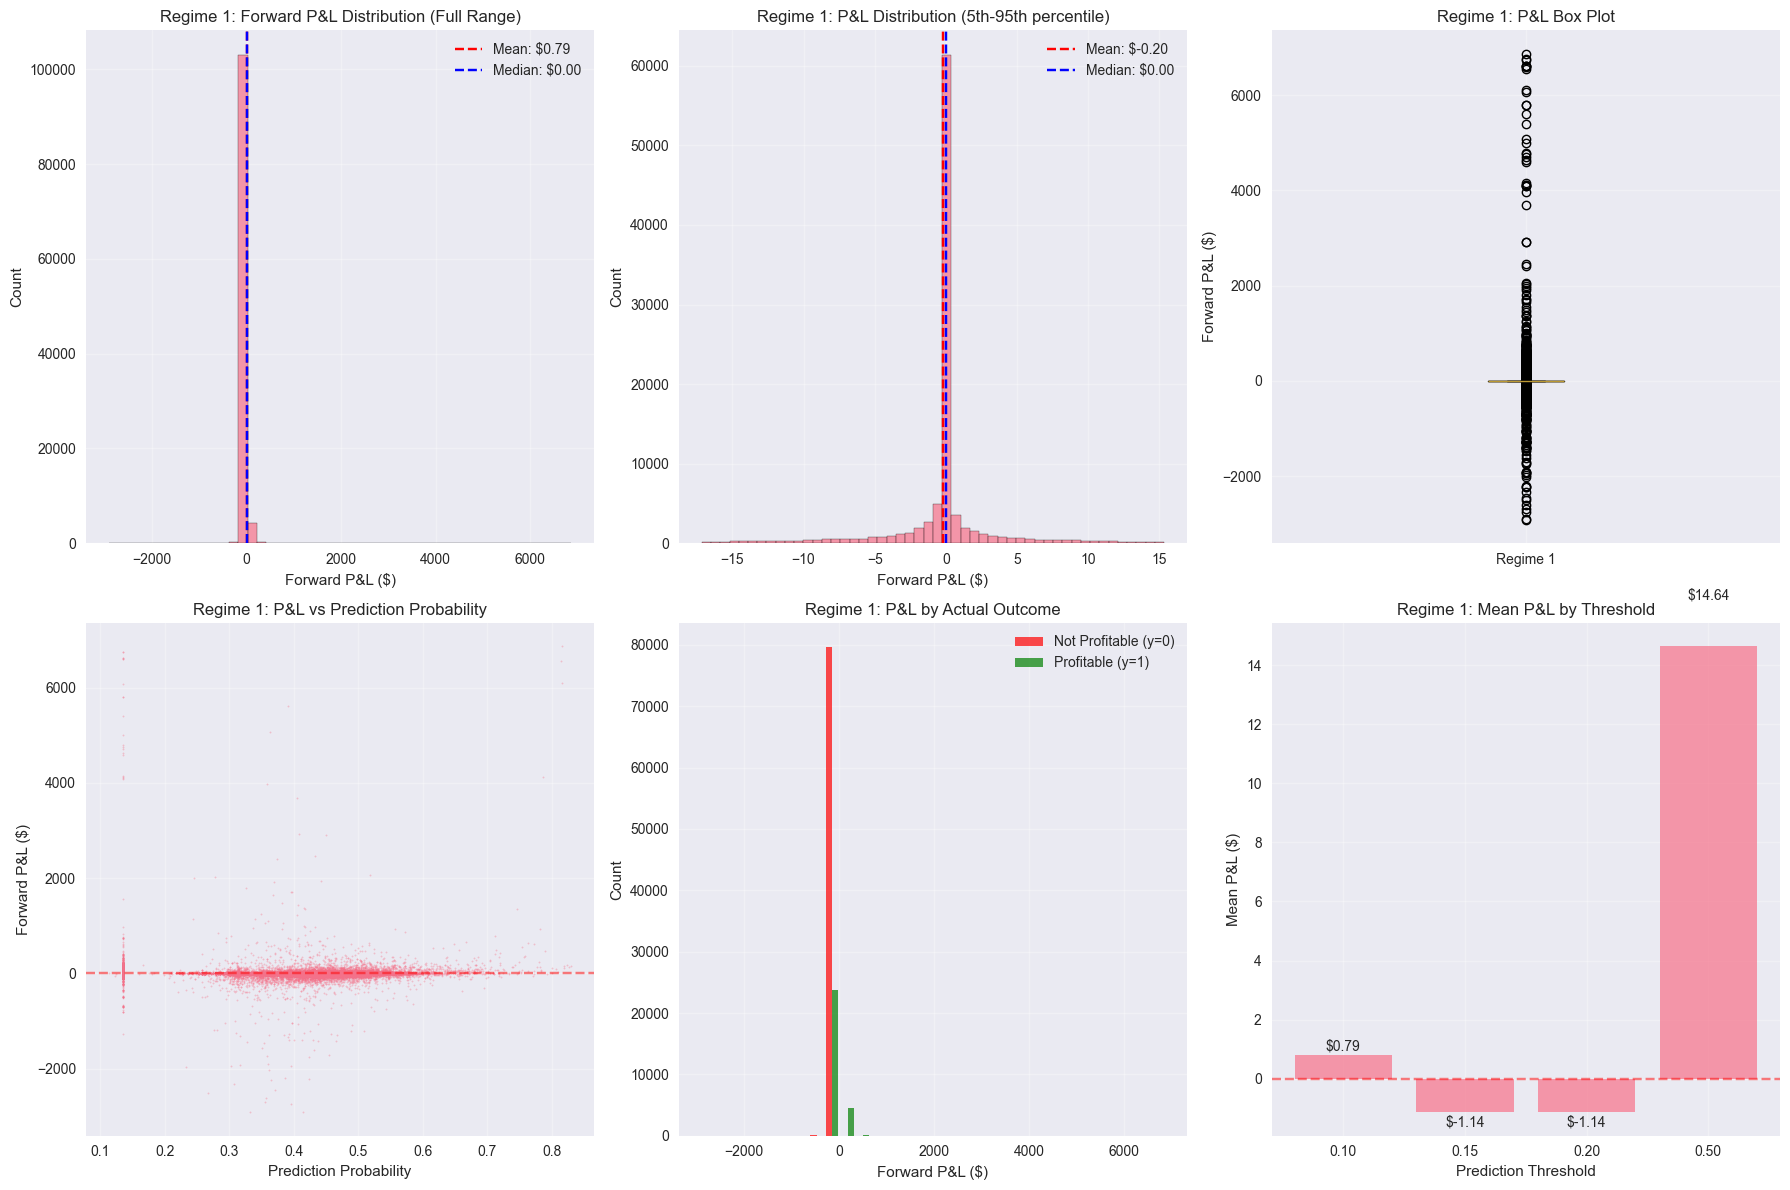


📊 THRESHOLD IMPACT ANALYSIS - REGIME 1
Threshold  Count    Mean P&L     Median P&L   Outliers  
----------------------------------------------------------------------
0.10       108209   $0.79        $0.00        45662     
0.15       49441    $-1.14       $-0.02       37319     
0.20       49434    $-1.14       $-0.02       37314     
0.50       5193     $14.64       $0.26        4283      

🎯 DETAILED ANALYSIS: WHY THRESHOLD 0.15 PERFORMS POORLY
Samples with prob 0.10-0.15 (excluded at 0.15): 58,768
  Mean P&L: $2.4078
  Median P&L: $0.0000
  Contains large positive outliers: 4,673

Samples with prob ≥0.15 (included at 0.15): 49,441
  Mean P&L: $-1.1400
  Median P&L: $-0.0153
  Contains large negative outliers: 20,028

💡 RECOMMENDATIONS FOR REGIME 1:
1. Consider outlier treatment (cap P&L at ±$0)
2. Use median-based metrics instead of mean for threshold optimization
3. Investigate why high-confidence predictions (≥0.15) perform poorly
4. Consider different threshold ranges (0.05-0.1

In [20]:
# Analyze forward P&L outliers for Regime 1
print("🔍 REGIME 1 FORWARD P&L OUTLIER ANALYSIS")
print("=" * 60)

# Filter data for Regime 1
regime_1_mask = regime_labels == 1
regime_1_pnl = actual_pnl[regime_1_mask]
regime_1_y_test = y_test[regime_1_mask]
regime_1_y_prob = y_prob[regime_1_mask]

print(f"Regime 1 P&L Statistics:")
print(f"  Count: {len(regime_1_pnl):,}")
print(f"  Mean: ${regime_1_pnl.mean():.4f}")
print(f"  Median: ${regime_1_pnl.median():.4f}")
print(f"  Std: ${regime_1_pnl.std():.4f}")
print(f"  Min: ${regime_1_pnl.min():.4f}")
print(f"  Max: ${regime_1_pnl.max():.4f}")

# Identify outliers using IQR method
Q1 = regime_1_pnl.quantile(0.25)
Q3 = regime_1_pnl.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (regime_1_pnl < lower_bound) | (regime_1_pnl > upper_bound)
print(f"\nOutlier Analysis (IQR method):")
print(f"  Q1: ${Q1:.4f}")
print(f"  Q3: ${Q3:.4f}")
print(f"  IQR: ${IQR:.4f}")
print(f"  Lower bound: ${lower_bound:.4f}")
print(f"  Upper bound: ${upper_bound:.4f}")
print(f"  Outliers: {outliers_mask.sum():,} ({outliers_mask.mean()*100:.1f}%)")

# Show extreme outliers
extreme_positive = regime_1_pnl > regime_1_pnl.quantile(0.99)
extreme_negative = regime_1_pnl < regime_1_pnl.quantile(0.01)

print(f"\nExtreme Outliers:")
print(f"  Top 1% (>${regime_1_pnl.quantile(0.99):.2f}): {extreme_positive.sum():,} samples")
print(f"  Bottom 1% (<${regime_1_pnl.quantile(0.01):.2f}): {extreme_negative.sum():,} samples")

if extreme_positive.sum() > 0:
    print(f"  Largest gains: ${regime_1_pnl[extreme_positive].max():.2f}")
if extreme_negative.sum() > 0:
    print(f"  Largest losses: ${regime_1_pnl[extreme_negative].min():.2f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. P&L Distribution (full range)
axes[0,0].hist(regime_1_pnl, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].axvline(regime_1_pnl.mean(), color='red', linestyle='--', label=f'Mean: ${regime_1_pnl.mean():.2f}')
axes[0,0].axvline(regime_1_pnl.median(), color='blue', linestyle='--', label=f'Median: ${regime_1_pnl.median():.2f}')
axes[0,0].set_xlabel('Forward P&L ($)')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Regime 1: Forward P&L Distribution (Full Range)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. P&L Distribution (zoomed, excluding extreme outliers)
pnl_95th = regime_1_pnl.quantile(0.95)
pnl_5th = regime_1_pnl.quantile(0.05)
moderate_pnl = regime_1_pnl[(regime_1_pnl >= pnl_5th) & (regime_1_pnl <= pnl_95th)]
axes[0,1].hist(moderate_pnl, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].axvline(moderate_pnl.mean(), color='red', linestyle='--', label=f'Mean: ${moderate_pnl.mean():.2f}')
axes[0,1].axvline(moderate_pnl.median(), color='blue', linestyle='--', label=f'Median: ${moderate_pnl.median():.2f}')
axes[0,1].set_xlabel('Forward P&L ($)')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Regime 1: P&L Distribution (5th-95th percentile)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Box plot
axes[0,2].boxplot([regime_1_pnl], labels=['Regime 1'])
axes[0,2].set_ylabel('Forward P&L ($)')
axes[0,2].set_title('Regime 1: P&L Box Plot')
axes[0,2].grid(True, alpha=0.3)

# 4. P&L vs Prediction Probability (scatter plot)
axes[1,0].scatter(regime_1_y_prob, regime_1_pnl, alpha=0.3, s=1)
axes[1,0].set_xlabel('Prediction Probability')  
axes[1,0].set_ylabel('Forward P&L ($)')
axes[1,0].set_title('Regime 1: P&L vs Prediction Probability')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 5. P&L vs Actual Outcome
profitable_pnl = regime_1_pnl[regime_1_y_test == 1]
unprofitable_pnl = regime_1_pnl[regime_1_y_test == 0]

axes[1,1].hist([unprofitable_pnl, profitable_pnl], bins=30, alpha=0.7, 
              label=['Not Profitable (y=0)', 'Profitable (y=1)'], color=['red', 'green'])
axes[1,1].set_xlabel('Forward P&L ($)')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Regime 1: P&L by Actual Outcome')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Threshold impact analysis
thresholds_to_analyze = [0.10, 0.15, 0.20, 0.50]
threshold_pnl_stats = []

for thresh in thresholds_to_analyze:
    thresh_mask = regime_1_y_prob >= thresh
    if thresh_mask.sum() > 0:
        thresh_pnl = regime_1_pnl[thresh_mask]
        threshold_pnl_stats.append({
            'threshold': thresh,
            'count': thresh_mask.sum(),
            'mean_pnl': thresh_pnl.mean(),
            'median_pnl': thresh_pnl.median(),
            'outlier_count': ((thresh_pnl < lower_bound) | (thresh_pnl > upper_bound)).sum()
        })

thresh_df = pd.DataFrame(threshold_pnl_stats)
x_pos = range(len(thresh_df))
bars = axes[1,2].bar(x_pos, thresh_df['mean_pnl'], alpha=0.7)
axes[1,2].set_xticks(x_pos)
axes[1,2].set_xticklabels([f"{t:.2f}" for t in thresh_df['threshold']])
axes[1,2].set_xlabel('Prediction Threshold')
axes[1,2].set_ylabel('Mean P&L ($)')
axes[1,2].set_title('Regime 1: Mean P&L by Threshold')
axes[1,2].grid(True, alpha=0.3)
axes[1,2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Add value labels on bars
for bar, mean_pnl in zip(bars, thresh_df['mean_pnl']):
    axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (bar.get_height()*0.1 if bar.get_height() > 0 else bar.get_height()*0.1), 
                  f'${mean_pnl:.2f}', ha='center', va='bottom' if bar.get_height() > 0 else 'top')

plt.tight_layout()
plt.show()

# Print threshold analysis details
print(f"\n📊 THRESHOLD IMPACT ANALYSIS - REGIME 1")
print("=" * 70)
print(f"{'Threshold':<10} {'Count':<8} {'Mean P&L':<12} {'Median P&L':<12} {'Outliers':<10}")
print("-" * 70)
for _, row in thresh_df.iterrows():
    print(f"{row['threshold']:<10.2f} {row['count']:<8.0f} ${row['mean_pnl']:<11.2f} "
          f"${row['median_pnl']:<11.2f} {row['outlier_count']:<10.0f}")

# Analyze what happens at threshold 0.15
print(f"\n🎯 DETAILED ANALYSIS: WHY THRESHOLD 0.15 PERFORMS POORLY")
print("=" * 60)

thresh_10_mask = regime_1_y_prob >= 0.10
thresh_15_mask = regime_1_y_prob >= 0.15

# Samples that are included at 0.10 but excluded at 0.15
excluded_at_15 = thresh_10_mask & ~thresh_15_mask
included_at_15 = thresh_15_mask

if excluded_at_15.sum() > 0 and included_at_15.sum() > 0:
    excluded_pnl = regime_1_pnl[excluded_at_15]
    included_pnl = regime_1_pnl[included_at_15]
    
    print(f"Samples with prob 0.10-0.15 (excluded at 0.15): {excluded_at_15.sum():,}")
    print(f"  Mean P&L: ${excluded_pnl.mean():.4f}")
    print(f"  Median P&L: ${excluded_pnl.median():.4f}")
    print(f"  Contains large positive outliers: {(excluded_pnl > upper_bound).sum():,}")
    
    print(f"\nSamples with prob ≥0.15 (included at 0.15): {included_at_15.sum():,}")
    print(f"  Mean P&L: ${included_pnl.mean():.4f}")
    print(f"  Median P&L: ${included_pnl.median():.4f}")
    print(f"  Contains large negative outliers: {(included_pnl < lower_bound).sum():,}")

# Recommendation
print(f"\n💡 RECOMMENDATIONS FOR REGIME 1:")
print("=" * 40)
print(f"1. Consider outlier treatment (cap P&L at ±${upper_bound:.0f})")
print(f"2. Use median-based metrics instead of mean for threshold optimization")
print(f"3. Investigate why high-confidence predictions (≥0.15) perform poorly")
print(f"4. Consider different threshold ranges (0.05-0.12) for Regime 1")

🔍 ZOOMED ANALYSIS: REGIME 1 PROB 0.1-0.2 vs FORWARD P&L
Samples in prob range 0.1-0.2: 58,775
Mean P&L: $2.4098
Median P&L: $0.0000
Std P&L: $104.0863
Min P&L: $-1274.9033
Max P&L: $6755.9645


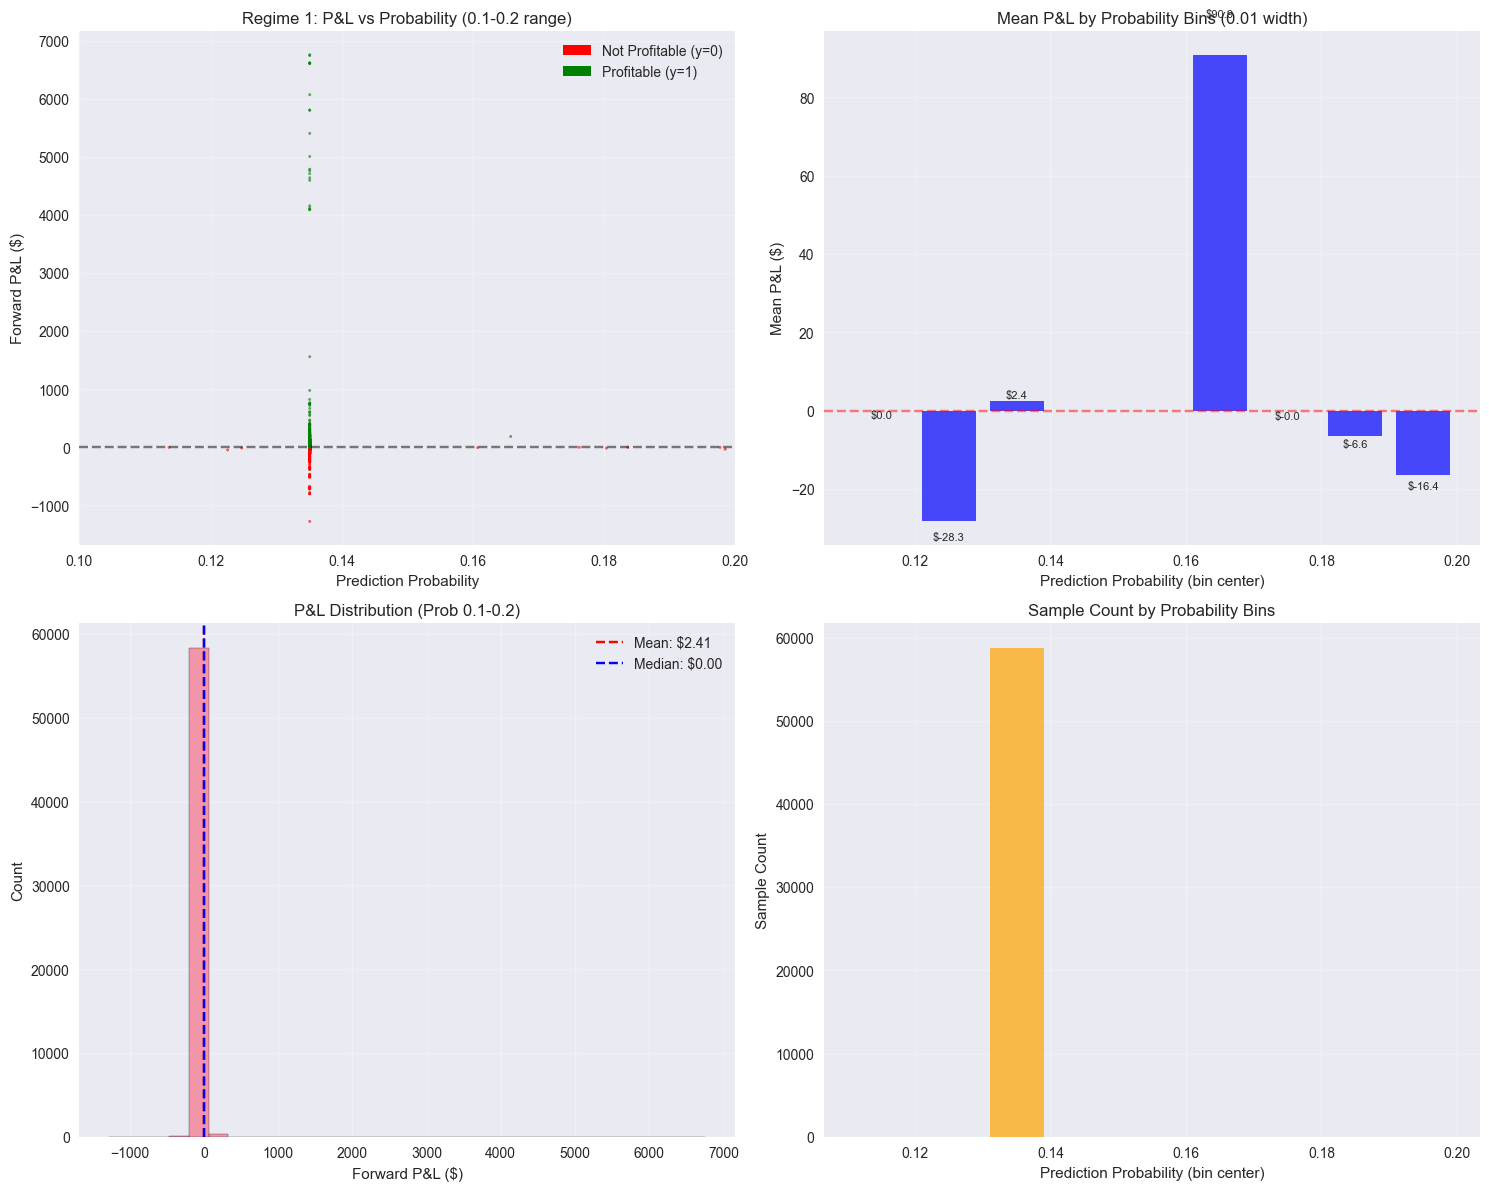


📊 DETAILED BIN ANALYSIS (0.1-0.2 range)
   bin_center  count   mean_pnl  median_pnl     std_pnl
0       0.115      1   0.000000    0.000000         NaN
1       0.125      2 -28.300112  -28.300112   23.774213
2       0.135  58765   2.408859    0.000000  104.092020
3       0.165      2  90.906114   90.906114  134.841434
4       0.175      1  -0.031226   -0.031226         NaN
5       0.185      2  -6.596396   -6.596396    9.264488
6       0.195      2 -16.424515  -16.424515   22.023494
------------------------------------------------------------
0.10-0.11   1       $0.00      $0.00        $nan      
0.11-0.12   2       $-28.30    $-28.30      $23.77    
0.12-0.13   58765   $2.41      $0.00        $104.09   
0.13-0.14   2       $90.91     $90.91       $134.84   
0.14-0.15   1       $-0.03     $-0.03       $nan      
0.15-0.16   2       $-6.60     $-6.60       $9.26     
0.16-0.17   2       $-16.42    $-16.42      $22.02    

🎯 KEY INSIGHTS:
Best performing bin: 0.17
  Mean P&L: $90.91
  S

In [26]:
# Zoom in plot: Prediction Probability (0.1-0.2) vs Forward P&L for Regime 1
print("🔍 ZOOMED ANALYSIS: REGIME 1 PROB 0.1-0.2 vs FORWARD P&L")
print("=" * 60)

# Filter for probability range 0.1 to 0.2
prob_range_mask = (regime_1_y_prob >= 0.1) & (regime_1_y_prob <= 0.2)
prob_range_prob = regime_1_y_prob[prob_range_mask]
prob_range_pnl = regime_1_pnl[prob_range_mask]
prob_range_y = regime_1_y_test[prob_range_mask]

print(f"Samples in prob range 0.1-0.2: {prob_range_mask.sum():,}")
print(f"Mean P&L: ${prob_range_pnl.mean():.4f}")
print(f"Median P&L: ${prob_range_pnl.median():.4f}")
print(f"Std P&L: ${prob_range_pnl.std():.4f}")
print(f"Min P&L: ${prob_range_pnl.min():.4f}")
print(f"Max P&L: ${prob_range_pnl.max():.4f}")

# Create detailed zoomed visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot with color by actual outcome
colors = ['red' if y == 0 else 'green' for y in prob_range_y]
scatter = axes[0,0].scatter(prob_range_prob, prob_range_pnl, c=colors, alpha=0.6, s=3)
axes[0,0].set_xlabel('Prediction Probability')
axes[0,0].set_ylabel('Forward P&L ($)')
axes[0,0].set_title('Regime 1: P&L vs Probability (0.1-0.2 range)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0,0].set_xlim(0.1, 0.2)

# Add legend manually
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Not Profitable (y=0)'),
                   Patch(facecolor='green', label='Profitable (y=1)')]
axes[0,0].legend(handles=legend_elements)

# 2. Binned analysis - divide 0.1-0.2 range into smaller bins
prob_bins = np.linspace(0.1, 0.2, 11)  # 10 bins of 0.01 each
bin_centers = (prob_bins[:-1] + prob_bins[1:]) / 2
bin_stats = []

for i in range(len(prob_bins) - 1):
    bin_mask = (prob_range_prob >= prob_bins[i]) & (prob_range_prob < prob_bins[i + 1])
    if bin_mask.sum() > 0:
        bin_pnl = prob_range_pnl[bin_mask]
        bin_stats.append({
            'bin_center': bin_centers[i],
            'count': bin_mask.sum(),
            'mean_pnl': bin_pnl.mean(),
            'median_pnl': bin_pnl.median(),
            'std_pnl': bin_pnl.std()
        })

bin_df = pd.DataFrame(bin_stats)

if not bin_df.empty:
    # Plot mean P&L by probability bin
    axes[0,1].bar(bin_df['bin_center'], bin_df['mean_pnl'], width=0.008, alpha=0.7, color='blue')
    axes[0,1].set_xlabel('Prediction Probability (bin center)')
    axes[0,1].set_ylabel('Mean P&L ($)')
    axes[0,1].set_title('Mean P&L by Probability Bins (0.01 width)')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Add value labels on bars
    for _, row in bin_df.iterrows():
        axes[0,1].text(row['bin_center'], row['mean_pnl'] + (row['mean_pnl']*0.1 if row['mean_pnl'] > 0 else row['mean_pnl']*0.1), 
                      f'${row["mean_pnl"]:.1f}', ha='center', va='bottom' if row['mean_pnl'] > 0 else 'top', fontsize=8)

# 3. Distribution of P&L in this probability range
axes[1,0].hist(prob_range_pnl, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].axvline(prob_range_pnl.mean(), color='red', linestyle='--', 
                 label=f'Mean: ${prob_range_pnl.mean():.2f}')
axes[1,0].axvline(prob_range_pnl.median(), color='blue', linestyle='--', 
                 label=f'Median: ${prob_range_pnl.median():.2f}')
axes[1,0].set_xlabel('Forward P&L ($)')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('P&L Distribution (Prob 0.1-0.2)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Sample count by probability bins
if not bin_df.empty:
    axes[1,1].bar(bin_df['bin_center'], bin_df['count'], width=0.008, alpha=0.7, color='orange')
    axes[1,1].set_xlabel('Prediction Probability (bin center)')
    axes[1,1].set_ylabel('Sample Count')
    axes[1,1].set_title('Sample Count by Probability Bins')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed bin analysis
if not bin_df.empty:
    print(f"\n📊 DETAILED BIN ANALYSIS (0.1-0.2 range)")
    print("=" * 60)
    print(bin_df)
    print("-" * 60)
    
    for i, row in bin_df.iterrows():
        prob_start = prob_bins[i]
        prob_end = prob_bins[i + 1]
        print(f"{prob_start:.2f}-{prob_end:.2f}   {row['count']:<7.0f} ${row['mean_pnl']:<9.2f} "
              f"${row['median_pnl']:<11.2f} ${row['std_pnl']:<9.2f}")

# Identify the specific probability ranges causing issues
print(f"\n🎯 KEY INSIGHTS:")
print("=" * 30)

if not bin_df.empty:
    # Find bins with highest and lowest mean P&L
    best_bin = bin_df.loc[bin_df['mean_pnl'].idxmax()]
    worst_bin = bin_df.loc[bin_df['mean_pnl'].idxmin()]
    
    print(f"Best performing bin: {best_bin['bin_center']:.2f}")
    print(f"  Mean P&L: ${best_bin['mean_pnl']:.2f}")
    print(f"  Sample count: {best_bin['count']:.0f}")
    
    print(f"\nWorst performing bin: {worst_bin['bin_center']:.2f}")
    print(f"  Mean P&L: ${worst_bin['mean_pnl']:.2f}")
    print(f"  Sample count: {worst_bin['count']:.0f}")
    
    print(f"\nP&L difference: ${best_bin['mean_pnl'] - worst_bin['mean_pnl']:.2f}")

# Count extreme outliers in this range
outlier_threshold = np.abs(prob_range_pnl).quantile(0.95)
extreme_outliers = np.abs(prob_range_pnl) > outlier_threshold
print(f"\nExtreme outliers (>95th percentile): {extreme_outliers.sum():,}")
if extreme_outliers.sum() > 0:
    print(f"  Outlier threshold: ±${outlier_threshold:.2f}")
    print(f"  Max absolute P&L: ${np.abs(prob_range_pnl).max():.2f}")
    
    # Show which probability ranges contain the most outliers
    for i, row in bin_df.iterrows():
        bin_mask = (prob_range_prob >= prob_bins[i]) & (prob_range_prob < prob_bins[i + 1])
        bin_outliers = np.abs(prob_range_pnl[bin_mask]) > outlier_threshold
        if bin_outliers.sum() > 0:
            prob_start = prob_bins[i]
            prob_end = prob_bins[i + 1]
            print(f"  Prob {prob_start:.2f}-{prob_end:.2f}: {bin_outliers.sum()} outliers")

# Findings

- 0.85 as a threshold is a safe one for 5mins hold and exit strategy
- Execute trades between first hour and 10 hours since trade start
- Regime 1 is interesting: 
    - low volume period, overall win rate is low, but average loss is low too
    - model seems to get it wrong sometimes, especially when the classification model produces 0.12-0.13 and 0.16-0.17 scores, could use this as a specifical signal to trade.